In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin

/work/sagarj/miniconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [4]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [5]:
shp.crs

{}

In [6]:
ward_frame = gpd.read_file('../Data/Geo_Data/wards_london_2016/London-wards-2018_ESRI/London_Ward.shp')
wardCodeDict = {}
for index , row in ward_frame.iterrows():
    wardCodeDict[row['NAME']] = row['GSS_CODE']

In [7]:
wardCodeDict

{'Chessington South': 'E05000405',
 'Tolworth and Hook Rise': 'E05000414',
 'Berrylands': 'E05000401',
 'Alexandra': 'E05000266',
 'Beverley': 'E05000402',
 'Coombe Hill': 'E05000406',
 'Chessington North and Hook': 'E05000404',
 'Surbiton Hill': 'E05000413',
 'Old Malden': 'E05000410',
 "St. Mark's": 'E05000412',
 'Grove': 'E05000408',
 'Canbury': 'E05000403',
 'Norbiton': 'E05000409',
 'Coombe Vale': 'E05000407',
 'St. James': 'E05000411',
 'Tudor': 'E05000415',
 'Coulsdon Town': 'E05011466',
 'Purley & Woodcote': 'E05011476',
 'Waddon': 'E05011487',
 'Old Coulsdon': 'E05011474',
 'Kenley': 'E05011469',
 'Purley Oaks & Riddlesdown': 'E05011477',
 'Sanderstead': 'E05011478',
 'Selsdon Vale & Forestdale': 'E05011481',
 'South Croydon': 'E05011484',
 'Selsdon & Addington Village': 'E05011480',
 'South Norwood': 'E05011485',
 'Shirly South': 'E05011483',
 'Shirley North': 'E05011482',
 'Broad Green': 'E05011465',
 'West Thornton': 'E05011488',
 'Bensham Manor': 'E05011464',
 'Norbury & P

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(657,
 5,
 [-0.510375074323337, 51.28676013985973, 0.0, 0.0],
 [0.3340155105948453, 51.6918741427417, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7ff702074d30>)

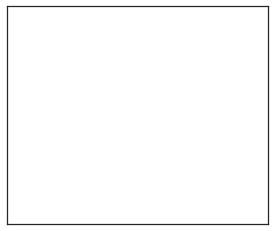

In [8]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/London-wards-2018_ESRI/London_Ward_WGS84',
    'London_Ward',
    color='none',
    zorder=2)

In [9]:
# m.London_Ward

In [10]:
m(58.6, -0)

(8455996.541404163, -5684368.573043259)

In [11]:
london_polys = []
borough_names = []
for w_ind in range(len(m.London_Ward_info)):
    w = m.London_Ward_info[w_ind]
    if w['GSS_CODE'] in borough_names:
        london_polys[-1] = Polygon(m.London_Ward[w_ind])
        continue
    borough_names.append(w['GSS_CODE'])    
    london_polys.append(Polygon(m.London_Ward[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [12]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'

In [13]:
pd.read_csv(data_file1,sep='|').head()

,WayID,PointID,Rotation,SegnetRatios
0,8363123,1077704848,0,"[0.27945023148148146, 0.09033564814814815, 0.0..."
1,16790097,173736413,0,"[0.2711574074074074, 0.24954282407407408, 0.00..."
2,7995502,1564517311,0,"[0.36464699074074075, 0.06125, 0.0211747685185..."
3,8375945,195712,0,"[0.2757118055555556, 0.14144675925925926, 0.00..."
4,2955913,629000,0,"[0.08201967592592592, 0.5701157407407408, 0.00..."


In [14]:
SegnetLabels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [15]:
gsview_lonlat = {}
fdata = {}
fdata_map_points = {}
gsview_data = {}
all_tags = {}
count = 0
threshold = 0.95

with open(lonlat_data_file, 'r') as infile:
    for line in infile:
        fields = line.strip().split(',')
        gsview_lonlat['_'.join([fields[0], fields[1], '0'])] = (float(fields[2]),float(fields[3]))               
        
count = 0
with open(data_file1, 'r') as infile:
    for line in infile:
        count += 1
        
        if count == 1:
            continue
        fields = line.strip().split('|')
        # ignore the rotation tag 0,1,2,4 for angle of rotation
        if len(fields) < 2:
            continue
        
        way_id   = fields[0]
        point_id = fields[1]
        rotation = fields[2]
        fields[3] = fields[3][1:-1]
        scene_list = list(map(float, fields[3].split(', ')))
        latitude  = gsview_lonlat['_'.join(fields[:3])][0]
        longitude = gsview_lonlat['_'.join(fields[:3])][1]
        fdata_map_points[m(longitude, latitude)] = scene_list

In [16]:
# fdata_map_points

In [17]:
map_points = pd.Series(
    [Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

In [24]:
len(df_map)

657

In [25]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [26]:
df_map.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Sign_Symbol,Sign_SymbolTotal,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal
0,"POLYGON ((13004.06542926727 5643.558746248193,...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,0.000928,0.095561,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023
1,"POLYGON ((16156.62105532554 9738.886960711214,...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,0.001452,0.152425,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911
2,"POLYGON ((14710.57419946622 12747.79583020677,...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,0.000871,0.050521,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625
3,"POLYGON ((16940.60990234993 10549.08843672881,...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,0.001190,0.098744,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128
4,"POLYGON ((17805.41752157114 14720.64437263657,...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,0.001375,0.108594,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488


In [27]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [28]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[2.14473380e-01, 1.17887731e-01, 1.55671296e-03, 1.72569444e-02,
        1.69722222e-01, 1.02228009e-01, 3.57835648e-01, 1.73611111e-05,
        7.62152778e-03, 9.91898148e-03, 1.48148148e-03, 0.00000000e+00],
       [3.06545139e-01, 3.56973380e-01, 1.01157407e-02, 5.60185185e-03,
        1.21377315e-01, 1.09994213e-01, 6.99074074e-03, 1.51620370e-03,
        1.28067130e-02, 6.32060185e-02, 4.75115741e-03, 1.21527778e-04],
       [2.22644676e-01, 7.37442130e-02, 2.27835648e-02, 7.52314815e-03,
        2.54444444e-01, 6.79861111e-02, 3.01377315e-01, 3.59953704e-03,
        6.55671296e-03, 3.54918981e-02, 3.40856481e-03, 4.39814815e-04],
       [1.53998843e-01, 6.09143519e-02, 1.41203704e-02, 3.35011574e-02,
        1.69849537e-01, 9.25289352e-02, 3.57615741e-01, 4.68750000e-04,
        1.08940972e-01, 7.59837963e-03, 1.33101852e-04, 3.29861111e-04],
       [3.29872685e-01, 1.25949074e-01, 9.37500000e-03, 3.52430556e-03,
        2.63275463e-01, 9.24826389e-02, 1.11278935e-01, 9.21

In [30]:
# len(zip(*scene_tags)[0])

In [31]:
# df_map = pd.read_csv('scratchpad/London_ward_tree_scores_stephen.csv')

In [32]:
len(df_map)

657

In [33]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Sky',
       'SkyTotal', 'Building', 'BuildingTotal', 'Pole', 'PoleTotal',
       'Road_Marking', 'Road_MarkingTotal', 'Road', 'RoadTotal', 'Pavement',
       'PavementTotal', 'Tree', 'TreeTotal', 'Sign_Symbol', 'Sign_SymbolTotal',
       'Fence', 'FenceTotal', 'Vehicle', 'VehicleTotal', 'Pedestrian',
       'PedestrianTotal', 'Bike', 'BikeTotal'],
      dtype='object')

In [34]:
df_map.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Sign_Symbol,Sign_SymbolTotal,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal
0,"POLYGON ((13004.06542926727 5643.558746248193,...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,0.000928,0.095561,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023
1,"POLYGON ((16156.62105532554 9738.886960711214,...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,0.001452,0.152425,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911
2,"POLYGON ((14710.57419946622 12747.79583020677,...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,0.000871,0.050521,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625
3,"POLYGON ((16940.60990234993 10549.08843672881,...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,0.001190,0.098744,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128
4,"POLYGON ((17805.41752157114 14720.64437263657,...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,0.001375,0.108594,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488


In [35]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv',encoding='latin-1')

/work/sagarj/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
len(tree_data)

726934

In [37]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

In [38]:
# print treeLocations[1]

In [39]:
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [40]:
df_map.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
0,"POLYGON ((13004.06542926727 5643.558746248193,...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.96312471858 9426.159779571637), ...",91
1,"POLYGON ((16156.62105532554 9738.886960711214,...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872404423 10953.03509159962), ...",53
2,"POLYGON ((14710.57419946622 12747.79583020677,...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625,[],0
3,"POLYGON ((16940.60990234993 10549.08843672881,...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709328765 11497.43654866517), ...",74
4,"POLYGON ((17805.41752157114 14720.64437263657,...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488,[],0


In [41]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Sky',
       'SkyTotal', 'Building', 'BuildingTotal', 'Pole', 'PoleTotal',
       'Road_Marking', 'Road_MarkingTotal', 'Road', 'RoadTotal', 'Pavement',
       'PavementTotal', 'Tree', 'TreeTotal', 'Sign_Symbol', 'Sign_SymbolTotal',
       'Fence', 'FenceTotal', 'Vehicle', 'VehicleTotal', 'Pedestrian',
       'PedestrianTotal', 'Bike', 'BikeTotal', 'Tree_location_list',
       'TreeCount'],
      dtype='object')

In [47]:
# import shapely.wkt
# df_map['poly'] = df_map['poly'].apply(shapely.wkt.loads)

In [48]:
gdf = gpd.GeoDataFrame(df_map, geometry='poly')

In [49]:
gdf.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
0,"POLYGON ((13004.065 5643.559, 13009.773 5652.2...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.96312471858 9426.159779571637), ...",91
1,"POLYGON ((16156.621 9738.887, 16111.702 9766.1...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872404423 10953.03509159962), ...",53
2,"POLYGON ((14710.574 12747.796, 14717.379 12751...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625,[],0
3,"POLYGON ((16940.610 10549.088, 16936.106 10550...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709328765 11497.43654866517), ...",74
4,"POLYGON ((17805.418 14720.644, 17808.519 14719...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488,[],0


In [50]:
# gdf.to_csv('Tree_Segnet.csv')

In [51]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [52]:
gdf['total_gsview_pixels'].iloc[2]

array([15.57875   ,  9.94159144,  0.4341956 ,  0.37415509,  9.69751157,
        4.88596644, 11.66291667,  0.05052083,  1.47177083,  3.56230324,
        0.24469329,  0.095625  ])

In [53]:
sum(gdf['TreeCount'])

725592

In [54]:
polygon = gdf.iloc[15]['poly']

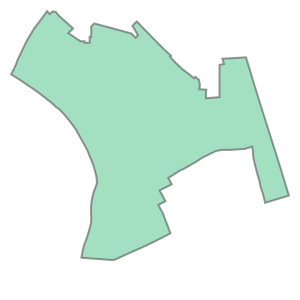

In [55]:
polygon

In [56]:
gdf.iloc[15].area_km

15.836952180062788

In [57]:
polygon.area

1583695.2180062789

In [58]:
# df_map.to_csv('Tree_Segnet.csv')

In [59]:
Area_wards = {'GSS_CODE':[] , 'Area':[]}
for index, row in gdf.iterrows():
    Area_wards['Area'].append(row['area_km']/10.0)
    Area_wards['GSS_CODE'].append(row['borough_name'])

In [60]:
Area_wards

{'GSS_CODE': ['E05000405',
  'E05000414',
  'E05000401',
  'E05000400',
  'E05000402',
  'E05000406',
  'E05000404',
  'E05000413',
  'E05000410',
  'E05000412',
  'E05000408',
  'E05000403',
  'E05000409',
  'E05000407',
  'E05000411',
  'E05000415',
  'E05011466',
  'E05011476',
  'E05011487',
  'E05011474',
  'E05011469',
  'E05011477',
  'E05011478',
  'E05011481',
  'E05011484',
  'E05011480',
  'E05011485',
  'E05011483',
  'E05011482',
  'E05011465',
  'E05011488',
  'E05011464',
  'E05011472',
  'E05011473',
  'E05011471',
  'E05011468',
  'E05011475',
  'E05011463',
  'E05011462',
  'E05011470',
  'E05011479',
  'E05011489',
  'E05011486',
  'E05011467',
  'E05000117',
  'E05000119',
  'E05000108',
  'E05000110',
  'E05000107',
  'E05000127',
  'E05000112',
  'E05000120',
  'E05000118',
  'E05000126',
  'E05000109',
  'E05000106',
  'E05000124',
  'E05000116',
  'E05000123',
  'E05000113',
  'E05000125',
  'E05000111',
  'E05000121',
  'E05000122',
  'E05000115',
  'E05000114'

In [61]:
WardAreas = pd.DataFrame.from_dict(Area_wards)

In [62]:
WardAreas

,GSS_CODE,Area
0,E05000405,7.557386
1,E05000414,2.596597
2,E05000401,1.454967
3,E05000400,2.687009
4,E05000402,1.879598
...,...,...
652,E05009289,0.112391
653,E05009295,0.081622
654,E05009299,0.150711
655,E05009308,0.062929


In [63]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = np.log(((gdf['TreeCount']+1)*10.0)/gdf['area_km'])
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [64]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Sky',
       'SkyTotal', 'Building', 'BuildingTotal', 'Pole', 'PoleTotal',
       'Road_Marking', 'Road_MarkingTotal', 'Road', 'RoadTotal', 'Pavement',
       'PavementTotal', 'Tree', 'TreeTotal', 'Sign_Symbol', 'Sign_SymbolTotal',
       'Fence', 'FenceTotal', 'Vehicle', 'VehicleTotal', 'Pedestrian',
       'PedestrianTotal', 'Bike', 'BikeTotal', 'Tree_location_list',
       'TreeCount', 'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'TreePixelDensity'],
      dtype='object')

In [65]:
gdf.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity
0,"POLYGON ((13004.065 5643.559, 13009.773 5652.2...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.96312471858 9426.159779571637), ...",91,0.004897,0.432440,2.499263,2.942246
1,"POLYGON ((16156.621 9738.887, 16111.702 9766.1...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872404423 10953.03509159962), ...",53,0.002852,0.297108,3.034782,6.002955
2,"POLYGON ((14710.574 12747.796, 14717.379 12751...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,0.004219,0.244693,0.001649,0.095625,[],0,0.000000,0.402745,-0.374983,8.015930
3,"POLYGON ((16940.610 10549.088, 16936.106 10550...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709328765 11497.43654866517), ...",74,0.003982,0.370921,3.329059,5.721579
4,"POLYGON ((17805.418 14720.644, 17808.519 14719...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,0.002800,0.221233,0.000981,0.077488,[],0,0.000000,0.282245,-0.631058,5.928132


In [66]:
gdf['GSV_samples_per_sqkm'] = 0
samplesPerWard = {}
for index, row in gdf.iterrows():
    samplesPerWard[row['borough_name']] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    gdf.at[index,'GSV_samples_per_sqkm'] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    

In [67]:
gdf['decile'] = pd.qcut(gdf['GSV_samples_per_sqkm'], q=10, precision=0)

In [68]:
gdf['decile_treeDensity'] = pd.qcut(gdf['TreeDensity'], q=10, precision=0)

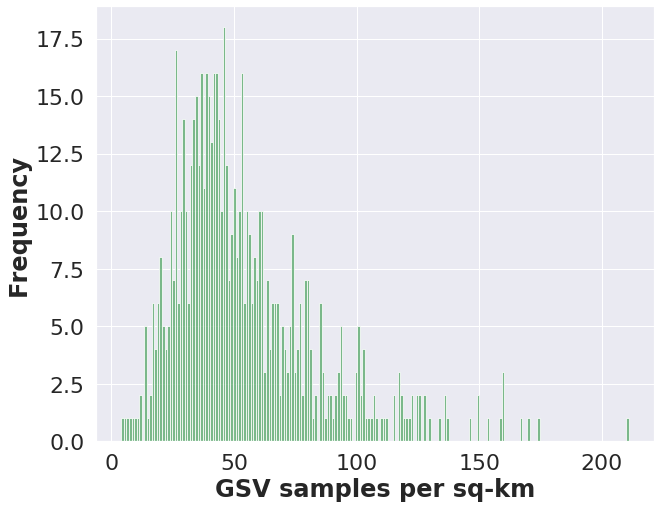

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('GSV samples per sq-km')
plt.ylabel('Frequency')
# plt.axvline(, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(samplesPerWard.values(), 200, facecolor='g', alpha=0.75)

In [70]:
min(gdf['TreeCount'])

0

In [71]:
len(gdf)

657

In [72]:
# df_map.head()

In [73]:
from scipy.stats import pearsonr

In [74]:
corr = pearsonr(gdf['TreeCount'],gdf['Tree'])
print(corr)

(0.31119927082766563, 3.21223264639796e-16)


Text(0.1, 0.55, 'Pearson r: 0.31***')

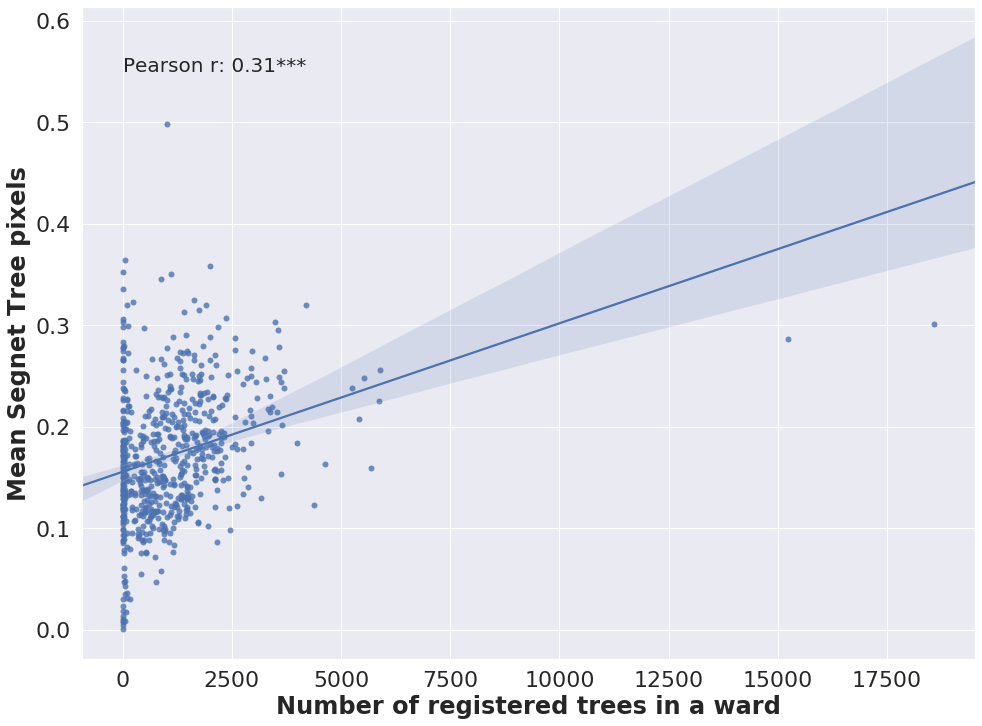

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeCount", y="Tree", data=gdf);
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Mean Segnet Tree pixels')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.1, 0.55),fontsize = 20)

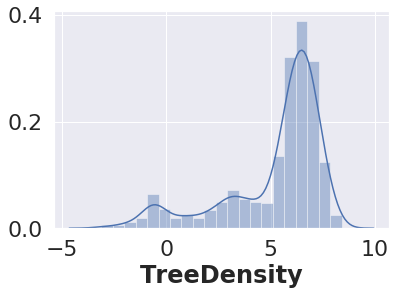

In [76]:
sns.distplot(gdf['TreeDensity'])

In [77]:
# greenScores = {}
# for index , row in gdf.iterrows():
#     greenScores[wardCodeDict[row['borough_name']]] = row['TreePixelDensity']

In [78]:
# import json
# json.dump(greenScores,open('London_ward_green_score.json','wb'))

(0.7031289173310846, 4.420740773465699e-99)


/work/sagarj/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


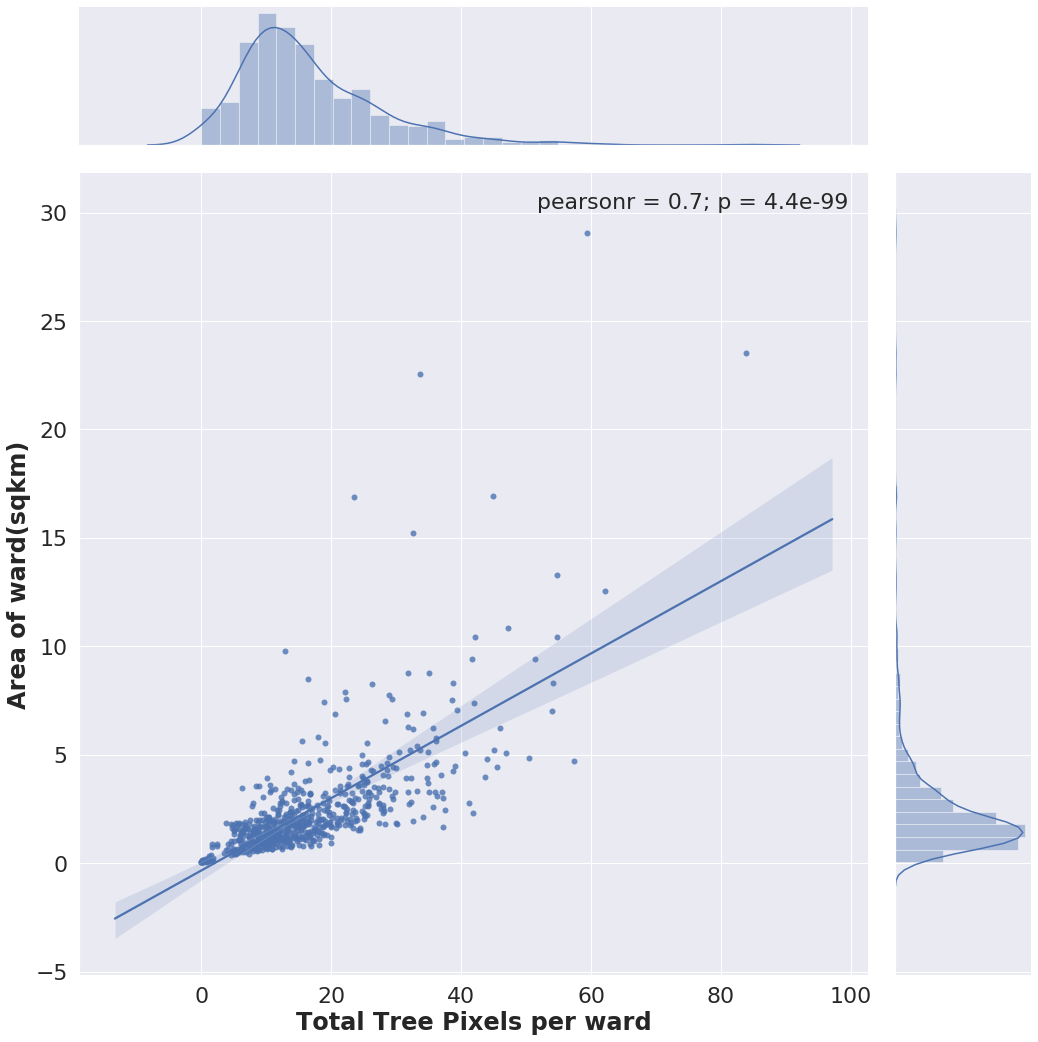

In [79]:
corr = pearsonr(gdf['TreeTotal'],gdf['area_km']/10)
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=gdf['TreeTotal'], y=gdf['area_km']/10,kind='regression',height=15);
plt.xlabel('Total Tree Pixels per ward')
plt.ylabel('Area of ward(sqkm)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [80]:
corrs = []
bins = []
for name, group in gdf.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])
    corrs.append(corr)

In [81]:
corrs

[(0.05855434948787777, 0.6378746345722526),
 (0.0037541494019303345, 0.9757610778082778),
 (-0.08174295419897303, 0.5140865514397931),
 (0.03555134923658843, 0.7734847464487747),
 (0.3316608379007454, 0.005728852292288621),
 (0.15170867872064517, 0.25561245044547865),
 (0.17754106145740361, 0.15062298698699608),
 (0.06197703954329388, 0.6183174195278386),
 (0.2570997261073912, 0.04193808364545546),
 (0.537381375174854, 3.919650332054619e-06)]

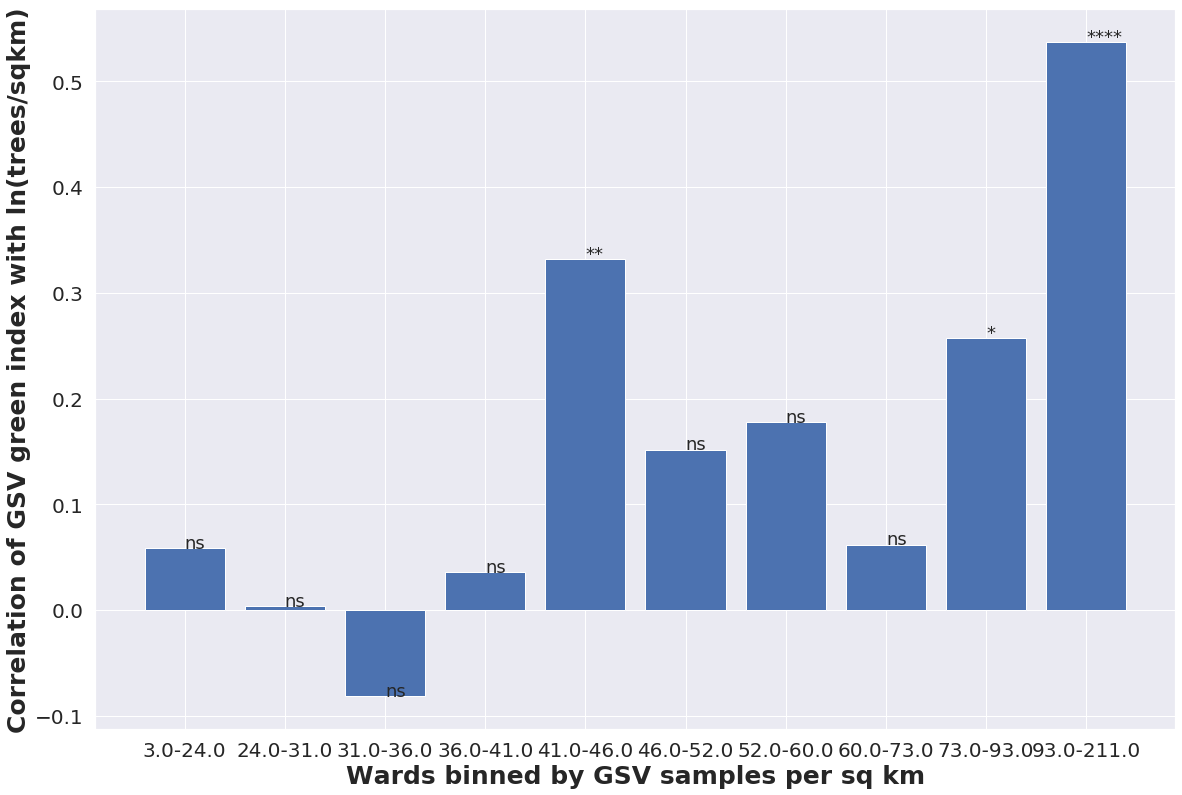

In [82]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by GSV samples per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [83]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['borough_name'], xy=(r["TreeDensity"], r["TreePixelDensity"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

(0.3916370100222678, 0.001146638815417884)
(0.022304374435069288, 0.8589102746531629)
(-0.14843846929869148, 0.23796865169688453)
(0.12912625459242838, 0.3014555915188246)
(0.01512401857545706, 0.9040654028740387)
(0.3101039384257622, 0.011939246598628411)
(-0.03681563570867826, 0.7691579582292462)
(0.05319635078915743, 0.6738579049554111)
(0.16021541448436233, 0.19877603361698132)
(0.4032060527827722, 0.00078851831774874)


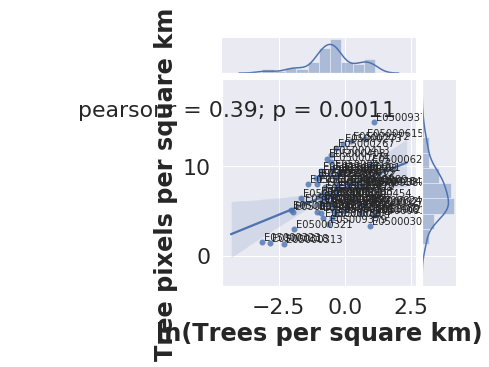

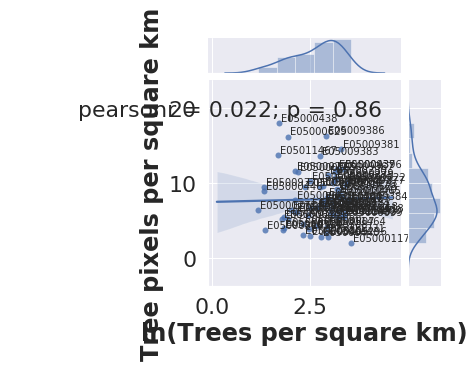

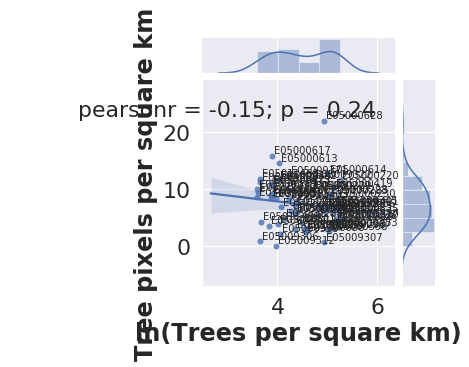

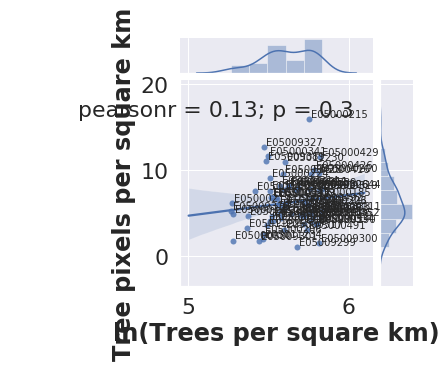

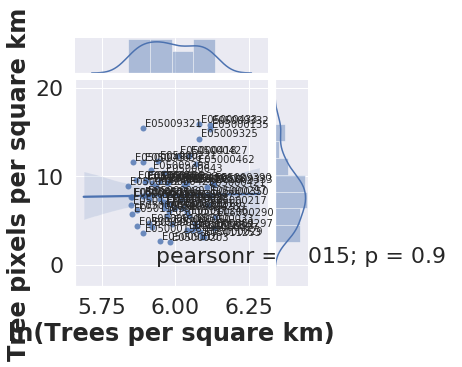

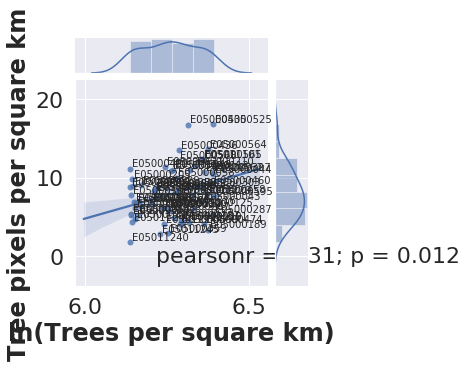

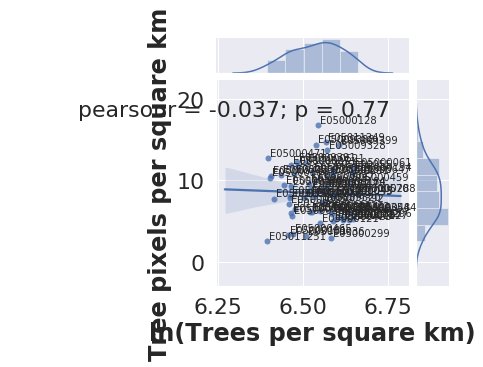

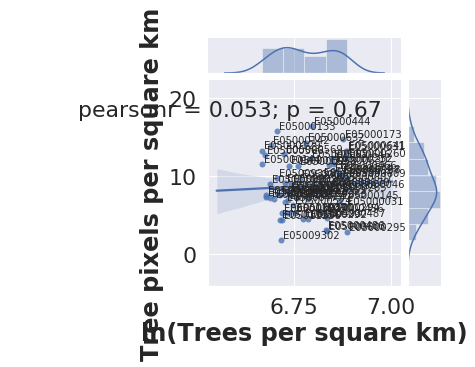

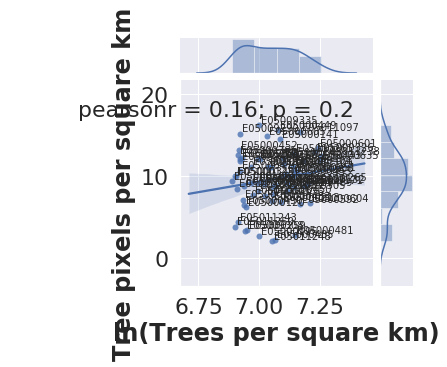

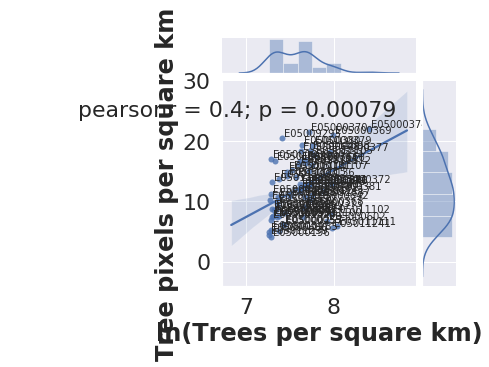

In [84]:
corrs_density = []
bins_density = []
for name, group in gdf.groupby('decile_treeDensity'):
    bins_density.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])

    print(corr)
    sns.set(font_scale=2) 
    ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=group,kind='regression',height=5);
    plt.xlabel('ln(Trees per square km)')
    plt.ylabel('Tree pixels per square km')
    ax.annotate(pearsonr)
    for row in group.iterrows():
        ann(row)
    corrs_density.append(corr)

In [85]:
corrs_density

[(0.3916370100222678, 0.001146638815417884),
 (0.022304374435069288, 0.8589102746531629),
 (-0.14843846929869148, 0.23796865169688453),
 (0.12912625459242838, 0.3014555915188246),
 (0.01512401857545706, 0.9040654028740387),
 (0.3101039384257622, 0.011939246598628411),
 (-0.03681563570867826, 0.7691579582292462),
 (0.05319635078915743, 0.6738579049554111),
 (0.16021541448436233, 0.19877603361698132),
 (0.4032060527827722, 0.00078851831774874)]

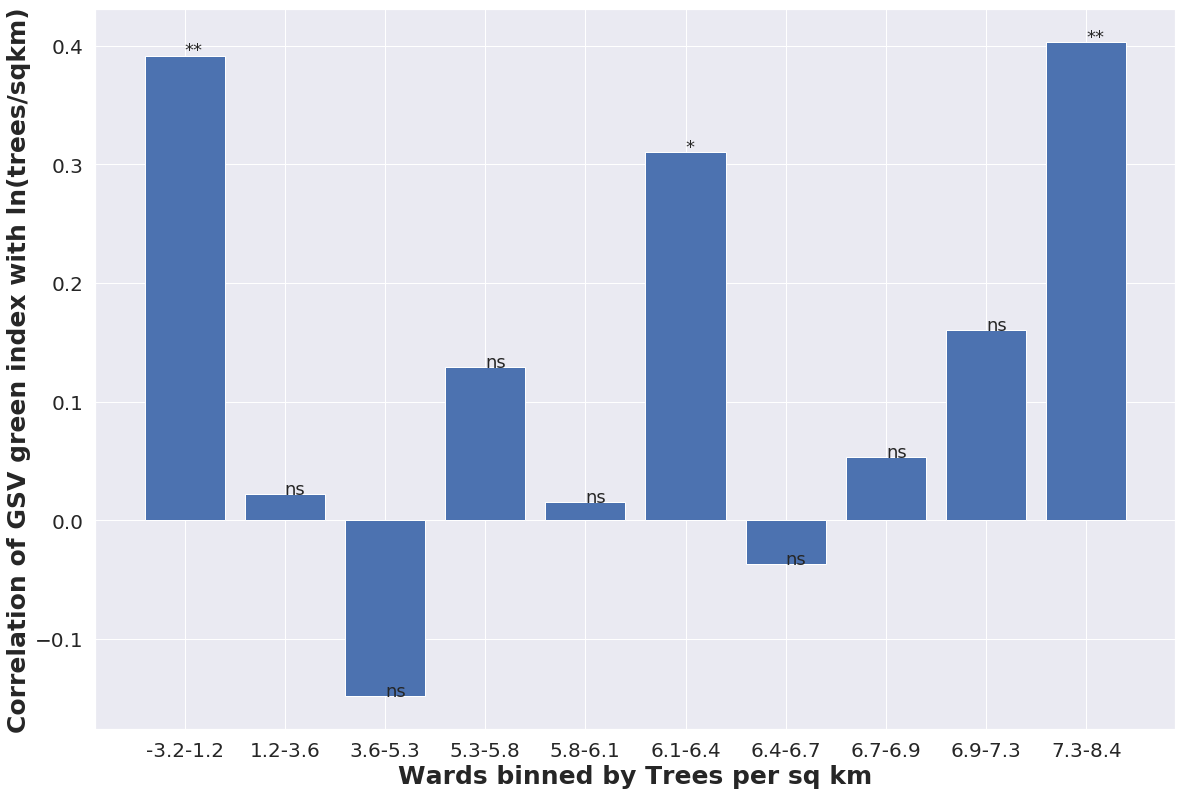

In [97]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Trees per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)[:5]+'-'+str(b.right)[:5] for b in bins_density]
c = [corr[0] for corr in corrs_density]
ax.bar(xlabels,c)

p = []
for corr in corrs_density: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [98]:
wardpop = pd.read_csv('../Data/Geo_Data/housing-density-ward.csv')

In [99]:
wardpop = wardpop.rename(columns={'Code': 'borough_name'})

In [100]:
wardpop = wardpop[wardpop['Year'] == 2018]

In [101]:
len(wardpop)

624

In [102]:
wardpop['borough_name'].nunique()

624

In [103]:
wardpop.head(n=10)

,borough_name,Borough,Ward_Name,Year,Population,Hectares,Square_Kilometres,Population_per_hectare,Population_per_square_kilometre
4368,E05000026,Barking and Dagenham,Abbey,2018,15297,127.9,1.279,119.601251,11960.125100
4369,E05000027,Barking and Dagenham,Alibon,2018,11266,136.1,1.361,82.777370,8277.736958
4370,E05000028,Barking and Dagenham,Becontree,2018,15088,128.4,1.284,117.507788,11750.778820
4371,E05000029,Barking and Dagenham,Chadwell Heath,2018,11210,338.0,3.380,33.165680,3316.568047
4372,E05000030,Barking and Dagenham,Eastbrook,2018,11100,345.4,3.454,32.136653,3213.665316
4373,E05000031,Barking and Dagenham,Eastbury,2018,12336,144.5,1.445,85.370242,8537.024221
4374,E05000032,Barking and Dagenham,Gascoigne,2018,14685,113.4,1.134,129.497355,12949.735450
4375,E05000033,Barking and Dagenham,Goresbrook,2018,12487,128.0,1.280,97.554688,9755.468750
4376,E05000034,Barking and Dagenham,Heath,2018,11995,200.5,2.005,59.825436,5982.543641
4377,E05000035,Barking and Dagenham,Longbridge,2018,12318,164.0,1.640,75.109756,7510.975610


In [104]:
tree = {}
tree_density = {}
tree_pixel_density = {}
pop_density = {}
pop = {}
names = []
for index, row in gdf.iterrows():
    wardname = row['borough_name']
    names.append(wardname)
    tree_density[wardname] = row['TreeDensity']
    tree[wardname] = row['TreeCount']
    tree_pixel_density[wardname] = row['TreePixelDensity']
    
for index,row in wardpop.iterrows():
    pop_density[row['borough_name']] = np.log10(row['Population_per_square_kilometre'])
    pop[row['borough_name']] = row['Population']
    
common =  set(wardpop['borough_name']).intersection(names)
        

In [105]:
# tree

In [106]:
# pop

In [107]:
tree_to_people_ratio = {} 
for k in pop:
    if k in tree:
        tree_to_people_ratio[k] = float(tree[k]+1)/float(pop[k])

In [108]:
vals = np.log10(list(tree_to_people_ratio.values()))
thresh_low = np.mean(vals) - np.sqrt(np.var(vals))
thresh_high = np.mean(vals) + np.sqrt(np.var(vals))

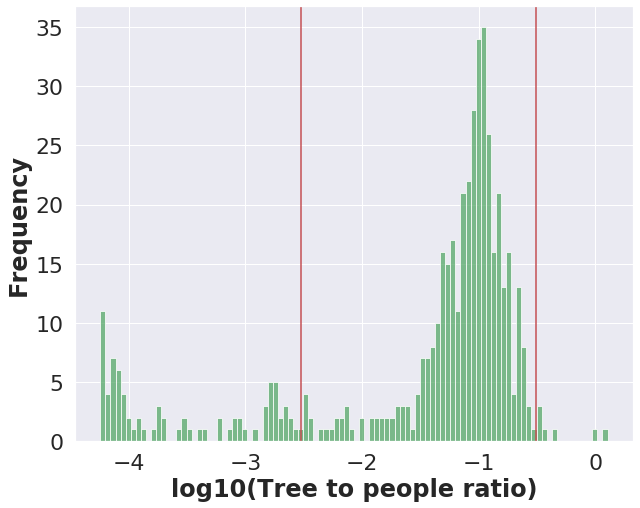

In [109]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

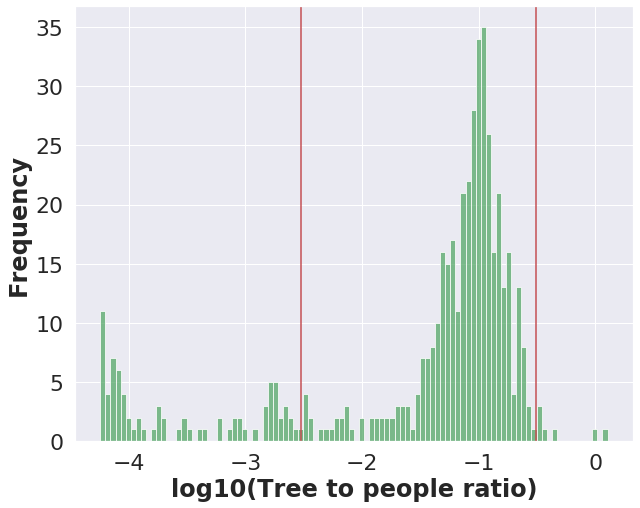

In [110]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

In [115]:
filteredCommon = [k for k in common if np.log10(tree_to_people_ratio[k]) < thresh_high and  np.log10(tree_to_people_ratio[k]) > thresh_low ]

In [116]:
# print ([k for k in common if np.log10(tree_to_people_ratio[k]) > thresh_high or  np.log10(tree_to_people_ratio[k]) < thresh_low ])

In [117]:
# sns.set(font_scale=2) 
# ax = sns.jointplot(x=[np.log(pop_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
# plt.xlabel('ln(Population Density)')
# plt.ylabel('ln(Tree density)')
# ax.annotate(pearsonr)

/work/sagarj/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


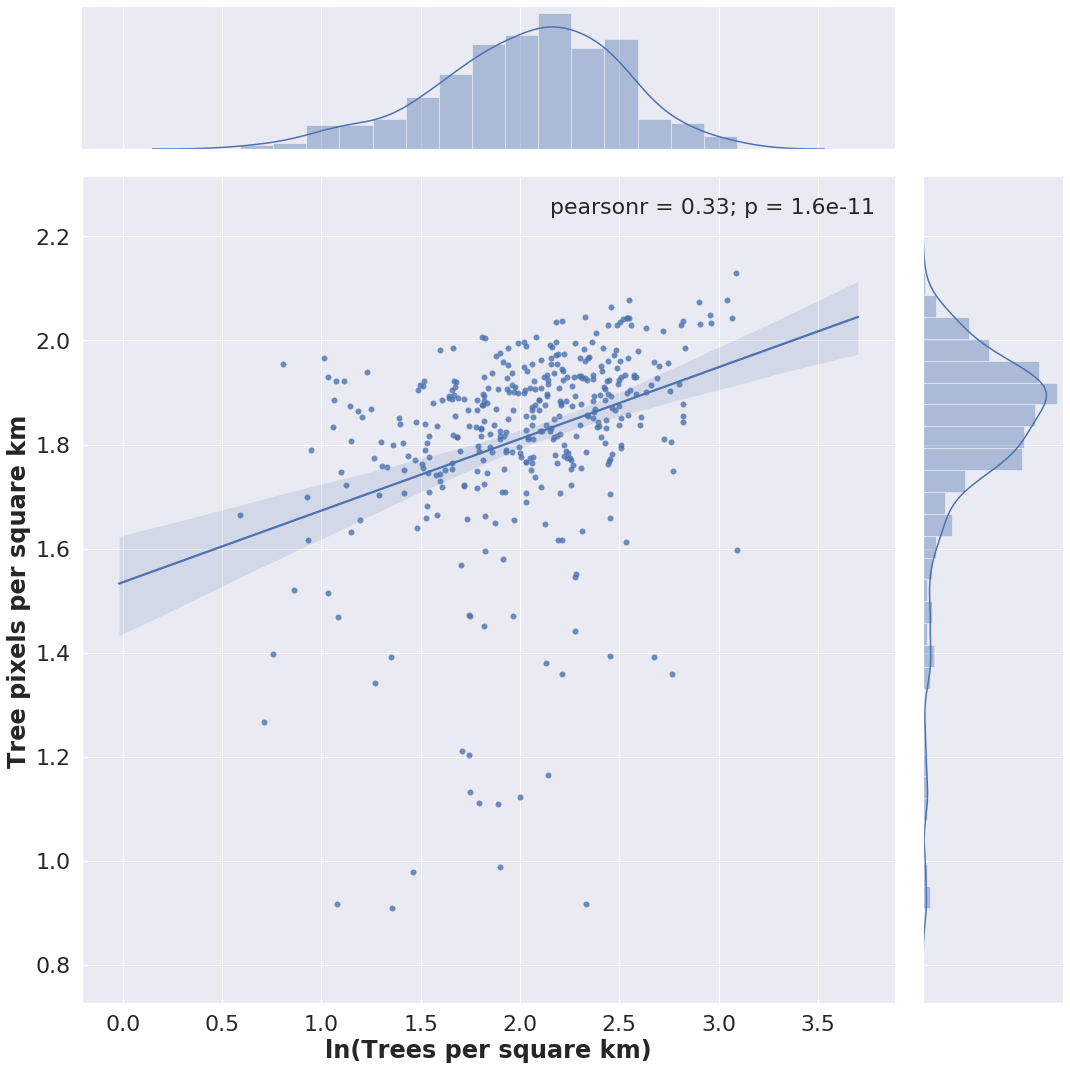

In [118]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(tree_pixel_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km')
ax.annotate(pearsonr)

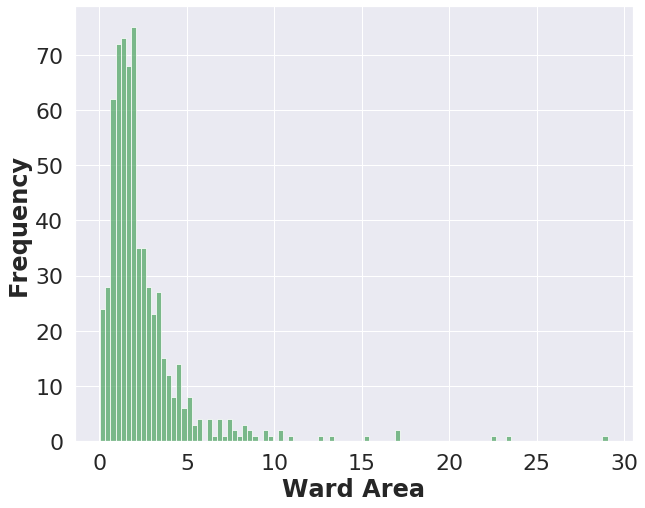

In [119]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10.0, 100, facecolor='g', alpha=0.75)

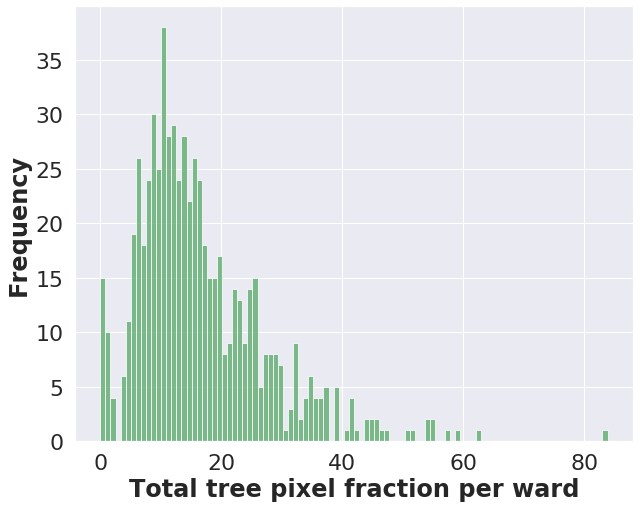

In [120]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeTotal'], 100, facecolor='g', alpha=0.75)

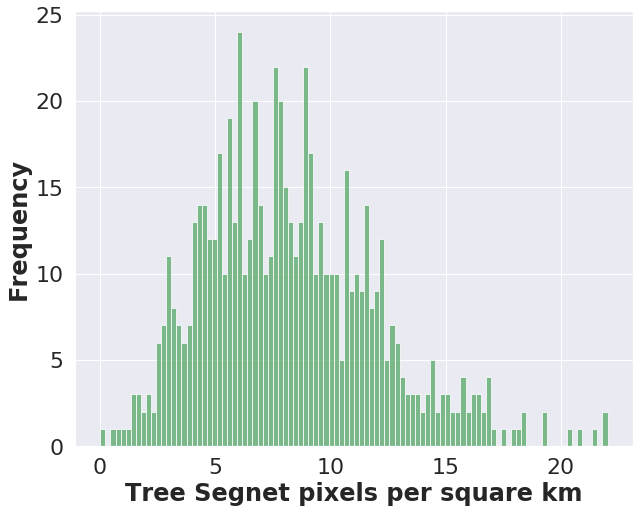

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

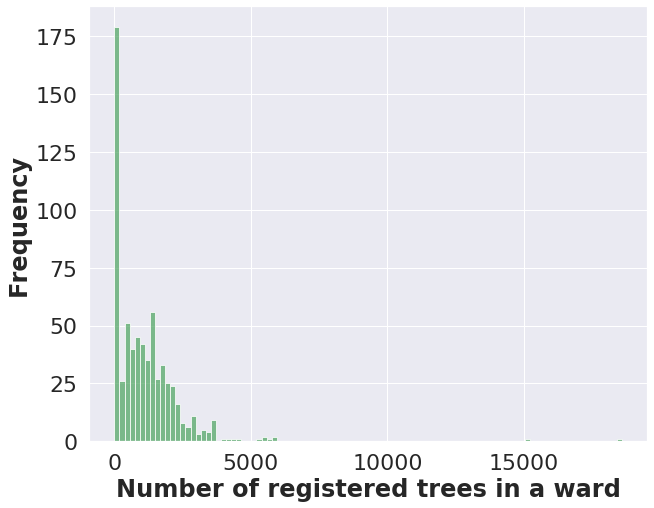

In [122]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeCount'], 100, facecolor='g', alpha=0.75)

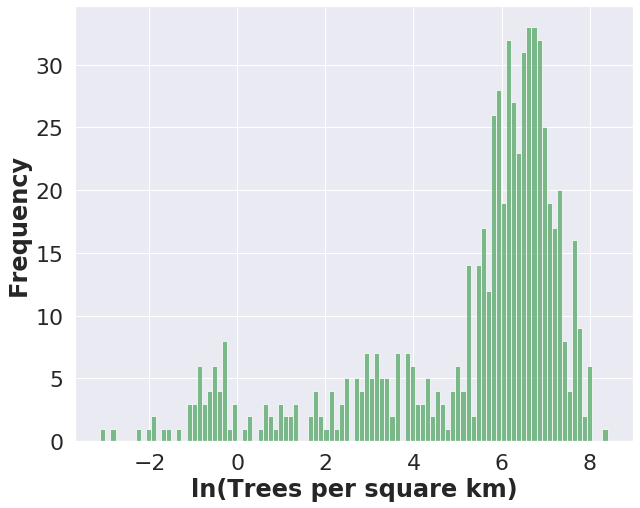

In [123]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeDensity'], 100, facecolor='g', alpha=0.75)

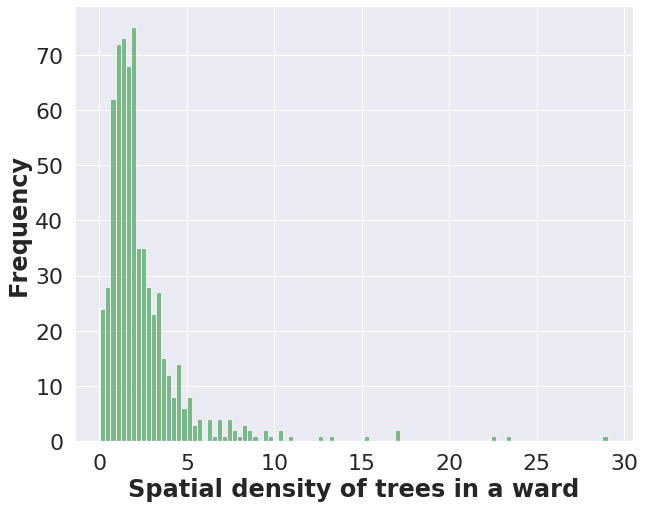

In [124]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10, 100, facecolor='g', alpha=0.75)

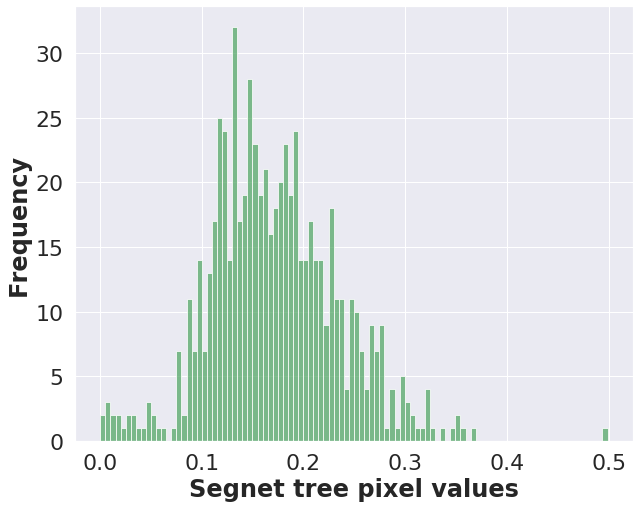

In [125]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['Tree'], 100, facecolor='g', alpha=0.75)

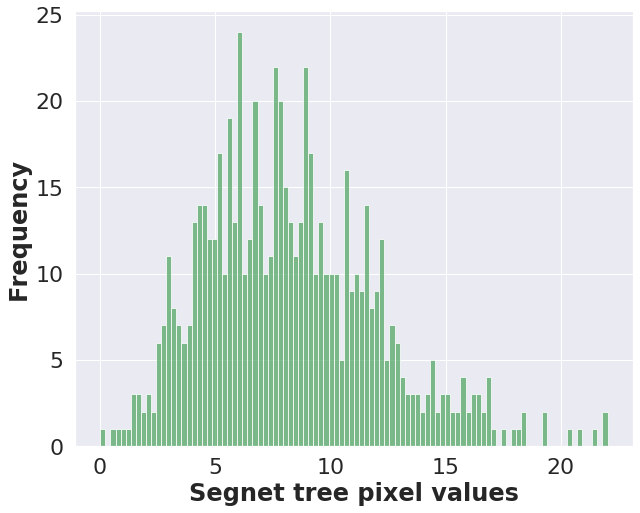

In [126]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

In [127]:
min(gdf['TreeCount'])

0

In [128]:
#Work with merging wards 
Wards_LSOA_2001 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2001_Lookup_in_England_and_Wales.csv')
Wards_LSOA_2011 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2011_Lookup_in_England_and_Wales.csv')

In [129]:
merged_Wards_LSOA = pd.merge(Wards_LSOA_2001, Wards_LSOA_2011, on='LSOA01CD', how='outer')

In [130]:
# merged_Wards_LSOA.to_csv('Merged_wards_LSOA_2001_2011.csv')
merged_Wards_LSOA.head()

,LSOA01CD,LSOA01NM_x,WD01CD,WD01NM,FID_x,LSOA01NM_y,WD11CD,WD11CDO,WD11NM,FID_y
0,E01012101,Redcar and Cleveland 001B,00EEMC,Coatham,12001,Redcar and Cleveland 001B,E05001506,00EENA,Coatham,12019
1,E01012351,Darlington 004C,00EHMW,North Road,12002,Darlington 004C,E05001571,00EHNX,North Road,12008
2,E01012102,Redcar and Cleveland 001C,00EEMC,Coatham,12003,Redcar and Cleveland 001C,E05001506,00EENA,Coatham,12023
3,E01012352,Darlington 004D,00EHMW,North Road,12004,Darlington 004D,E05001571,00EHNX,North Road,12010
4,E01012353,Darlington 008B,00EHMU,Northgate South,12005,Darlington 008B,E05001572,00EHNY,Northgate,12011


In [131]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data/uk_ward_greenspace.csv')

In [132]:
ward_csv_CRESH.head()

,casward2001,greenspace_pc
0,00AAFA,8.383184
1,00AAFE,24.354640
2,00AAFQ,10.795210
3,00AAFS,22.745890
4,00AAFT,22.767050


In [133]:
WardMap = {}
for index , row in merged_Wards_LSOA.iterrows():
    WardMap[row['WD11CDO']] = row['WD11CD']

In [134]:
len(WardMap)

8541

In [135]:
# json.dump(WardMap , open("CAS_NEW_WARD_MAPPING.json",'w'))

In [136]:
len(set(ward_csv_CRESH['casward2001']).intersection(list(merged_Wards_LSOA['WD11CDO'])))

6492

In [137]:
MedIx_score_wards = {}
CAS_New_Map = {}
for index,row in ward_csv_CRESH.iterrows():
    old = row ['casward2001']
    if old in WardMap:
        MedIx_score_wards[WardMap[old]] = row['greenspace_pc']

In [138]:
MedIx_score_wards

{'E05000001': 8.383184,
 'E05000015': 10.79521,
 'E05000021': 17.16018,
 'E05000026': 15.685620000000002,
 'E05000027': 24.04374,
 'E05000028': 18.21998,
 'E05000029': 56.84335,
 'E05000030': 58.17402,
 'E05000031': 19.18874,
 'E05000032': 13.779910000000001,
 'E05000033': 14.4604,
 'E05000034': 40.23384,
 'E05000035': 29.751509999999996,
 'E05000036': 42.36457,
 'E05000037': 24.67846,
 'E05000038': 42.90501,
 'E05000039': 53.80516,
 'E05000040': 20.13458,
 'E05000041': 50.89484,
 'E05000042': 29.498559999999998,
 'E05000043': 19.94054,
 'E05000044': 14.8701,
 'E05000045': 26.283559999999998,
 'E05000046': 17.68908,
 'E05000047': 18.65261,
 'E05000048': 40.46021,
 'E05000049': 37.2539,
 'E05000050': 57.164640000000006,
 'E05000051': 18.5158,
 'E05000052': 25.74407,
 'E05000053': 22.36515,
 'E05000054': 50.030879999999996,
 'E05000055': 24.45143,
 'E05000056': 60.06723,
 'E05000057': 57.10446999999999,
 'E05000058': 21.5744,
 'E05000059': 60.85955,
 'E05000060': 47.09506,
 'E05000061': 

In [203]:
# %store MedIx_score_wards

In [139]:
json.dump(MedIx_score_wards,open('Ward_medix_deprivation.json','w'))

In [140]:
# GLUD_green = pd.read_csv('../../BL_Work/london_wards_green_pixels_average.csv')
GLUD_green = pd.read_csv('scratchpad/satellite_borne_green_indices_percent.csv')

In [143]:
len(GLUD_green)

483

In [144]:
GLUD_green.head()

,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT
0,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379
1,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538
2,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912
3,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167
4,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611


In [145]:
MedixDf = pd.DataFrame.from_dict(MedIx_score_wards,orient='index')
MedixDf['GSS_CODE'] = MedixDf.index
MedixDf = MedixDf.rename(columns={0: 'green_score'})

In [146]:
MedixDf.head()


,green_score,GSS_CODE
E05000001,8.383184,E05000001
E05000015,10.795210,E05000015
E05000021,17.160180,E05000021
E05000026,15.685620,E05000026
E05000027,24.043740,E05000027


In [147]:
len(GLUD_green)

483

In [148]:
len(MedixDf)

6492

In [149]:
MergedGLUD_1 = pd.merge(MedixDf, GLUD_green, left_on='GSS_CODE' , right_on='WD17CD')

In [150]:
len(MergedGLUD_1)

483

In [151]:
MergedGLUD = pd.merge(MergedGLUD_1, gdf, left_on='GSS_CODE' , right_on='borough_name')

In [152]:
MergedGLUD.head()

,green_score,GSS_CODE,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT,...,BikeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity,GSV_samples_per_sqkm,decile,decile_treeDensity
0,15.68562,E05000026,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379,...,0.034832,"[POINT (40589.626862391 29851.74894456787), PO...",1085,0.058384,0.226256,6.740372,7.755388,68,"(60.0, 73.0]","(6.7, 6.9]"
1,24.04374,E05000027,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538,...,0.026007,"[POINT (45981.11760925724 31256.39461431676), ...",598,0.032178,0.213582,6.083775,3.677250,34,"(31.0, 36.0]","(5.8, 6.1]"
2,18.21998,E05000028,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912,...,0.051291,"[POINT (43876.03465504579 31917.62967057113), ...",509,0.027389,0.268658,5.980515,6.874977,51,"(46.0, 52.0]","(5.8, 6.1]"
3,56.84335,E05000029,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167,...,0.047384,"[POINT (44934.11192905133 35047.59410061041), ...",1503,0.080876,0.261193,6.096027,3.161049,24,"(3.0, 24.0]","(5.8, 6.1]"
4,58.17402,E05000030,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611,...,0.035532,"[POINT (47895.12394428799 31835.71821949573), ...",678,0.036483,0.204336,5.281338,1.805823,17,"(3.0, 24.0]","(5.3, 5.8]"


In [153]:
len(MergedGLUD)

483

(-0.8536668353680863, 2.2676357792110097e-138)


Text(29, 0.25, 'Pearson r: -0.8***')

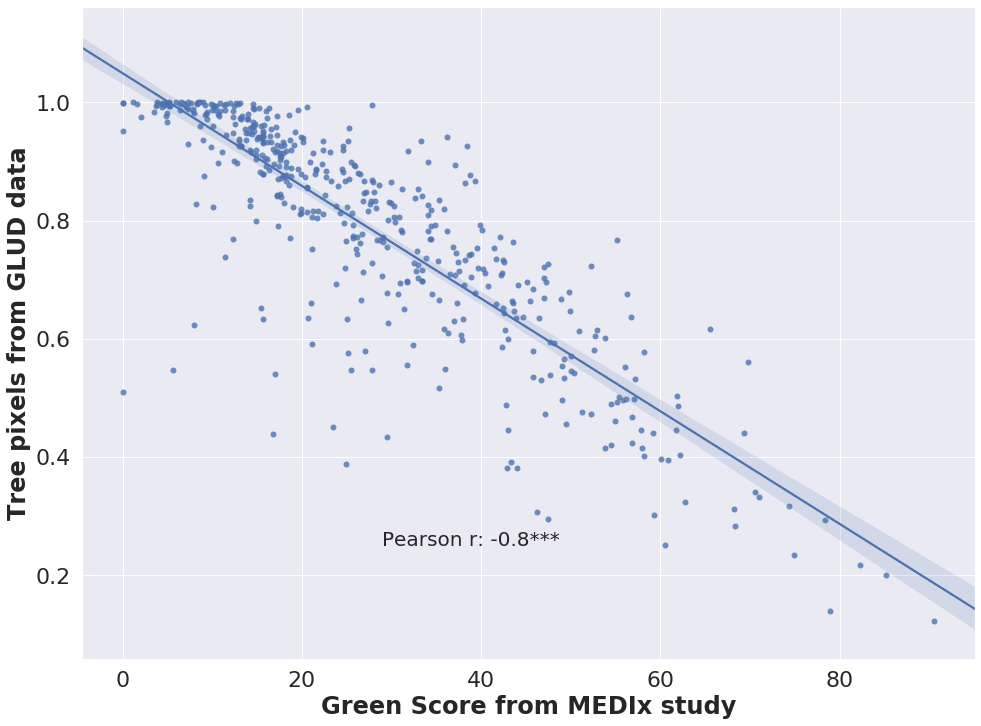

In [155]:
corr = pearsonr(MergedGLUD['green_score'],MergedGLUD['LCM_urban_pct'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="green_score", y="LCM_urban_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [157]:
# corr = pearsonr(MergedGLUD['TreeScore'],MergedGLUD['LCM_urban_pct'])
# print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.regplot(x="TreeScore", y="LCM_urban_pct", data=MergedGLUD);
# plt.xlabel('Green Score from MEDIx study')
# plt.ylabel('Tree pixels from GLUD data')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [160]:
# corr = pearsonr(MergedGLUD['TreeScore'],MergedGLUD['StreetTrees_PCT'])
# print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.regplot(x="TreeScore", y="StreetTrees_PCT", data=MergedGLUD);
# plt.xlabel('Green Score from MEDIx study')
# plt.ylabel('Tree pixels from GLUD data')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [161]:
len(MergedGLUD)

483

In [162]:
merged_inner_GSV = MergedGLUD

In [163]:
merged_inner_GSV.head()

,green_score,GSS_CODE,WD17CD,GLUD_Area of Greenspace PCT,LCM_grass_pct,LCM_tree_pct,LCM_urban_pct,UA_Public Greenery PCT,UA_Forests PCT,StreetTrees_PCT,...,BikeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity,GSV_samples_per_sqkm,decile,decile_treeDensity
0,15.68562,E05000026,E05000026,0.199622,0.024752,0.009194,0.932815,0.064844,0.0,0.034379,...,0.034832,"[POINT (40589.626862391 29851.74894456787), PO...",1085,0.058384,0.226256,6.740372,7.755388,68,"(60.0, 73.0]","(6.7, 6.9]"
1,24.04374,E05000027,E05000027,0.229128,0.138156,0.000000,0.858260,0.256912,0.0,0.068538,...,0.026007,"[POINT (45981.11760925724 31256.39461431676), ...",598,0.032178,0.213582,6.083775,3.677250,34,"(31.0, 36.0]","(5.8, 6.1]"
2,18.21998,E05000028,E05000028,0.058343,0.122918,0.000000,0.876416,0.157805,0.0,0.047912,...,0.051291,"[POINT (43876.03465504579 31917.62967057113), ...",509,0.027389,0.268658,5.980515,6.874977,51,"(46.0, 52.0]","(5.8, 6.1]"
3,56.84335,E05000029,E05000029,0.741304,0.185813,0.004209,0.423620,0.046093,0.0,0.174167,...,0.047384,"[POINT (44934.11192905133 35047.59410061041), ...",1503,0.080876,0.261193,6.096027,3.161049,24,"(3.0, 24.0]","(5.8, 6.1]"
4,58.17402,E05000030,E05000030,0.459967,0.292064,0.030131,0.577416,0.459714,0.0,0.072611,...,0.035532,"[POINT (47895.12394428799 31835.71821949573), ...",678,0.036483,0.204336,5.281338,1.805823,17,"(3.0, 24.0]","(5.3, 5.8]"


In [165]:
# sns.distplot(merged_inner_GSV['TreeScore'])

In [166]:
# corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['TreeScore'])
# print corr
# # fig, ax = plt.subplots()
# # fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.jointplot(x="LCM_tree_pct", y="TreeScore", data=merged_inner_GSV,kind='regression',height=15);
# plt.xlabel('Grass percentage score from LCM')
# plt.ylabel('Ward Green Score from MEDIx study')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [167]:
# corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['green_score'])
# print corr
# # fig, ax = plt.subplots()
# # fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.jointplot(x="LCM_tree_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
# plt.xlabel('Tree percentage score from LCM ')
# plt.ylabel('Ward Tree scores from CRESH')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [168]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [169]:
diseases['201604'].keys()

dict_keys(['Ward_Prevalence', 'Ward_Prescriptions'])

In [170]:
diseases['201604']['Ward_Prescriptions'].keys()

dict_keys(['psoriasis', "Meniere's disease", "crohn's disease", 'rheumatoid', 'irritable bowel syndrome', 'parkinson', 'sleep apnea', 'interstitial cystitis', 'bipolar', 'hypothyroidism', 'dementia', 'gastroparesis', 'depression', 'diabetes'])

In [171]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , diseaseName + '_Prescriptions' : [] , diseaseName+'_Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data[diseaseName + '_Prescriptions'].append(dictionary1[k])
            data[diseaseName + '_Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe
    
    
def allDisease_frame(disease_dict,month):
    diseases = list(disease_dict[month]['Ward_Prescriptions'].keys())
    print(diseases)
    df = getDiseaase_frame(disease_dict, month , diseases[0])
    print(len(df))
    for k in diseases[1:]:
        print("Doing %s"%k)
        df2 = getDiseaase_frame(disease_dict, month , k)
        df3 = pd.merge(left=df,right=df2, left_on='GSS_CODE', right_on='GSS_CODE')
        df = df3.copy()
    return df

In [172]:
allDisease_df = allDisease_frame(diseases, '201805')

['psoriasis', "Meniere's disease", "crohn's disease", 'rheumatoid', 'irritable bowel syndrome', 'parkinson', 'sleep apnea', 'interstitial cystitis', 'bipolar', 'hypothyroidism', 'dementia', 'gastroparesis', 'depression', 'diabetes']
7483
Doing Meniere's disease
Doing crohn's disease
Doing rheumatoid
Doing irritable bowel syndrome
Doing parkinson
Doing sleep apnea
Doing interstitial cystitis
Doing bipolar
Doing hypothyroidism
Doing dementia
Doing gastroparesis
Doing depression
Doing diabetes


In [173]:
allDisease_df.head()

,GSS_CODE,psoriasis_Prescriptions,psoriasis_Prevalence,Meniere's disease_Prescriptions,Meniere's disease_Prevalence,crohn's disease_Prescriptions,crohn's disease_Prevalence,rheumatoid_Prescriptions,rheumatoid_Prevalence,irritable bowel syndrome_Prescriptions,...,hypothyroidism_Prescriptions,hypothyroidism_Prevalence,dementia_Prescriptions,dementia_Prevalence,gastroparesis_Prescriptions,gastroparesis_Prevalence,depression_Prescriptions,depression_Prevalence,diabetes_Prescriptions,diabetes_Prevalence
0,E05002284,681.605968,0.131331,93.931563,0.018099,39.918525,0.007691,41605.866189,8.016545,253.984859,...,51096.192794,9.845124,3347.990651,0.645085,1926.091188,0.371116,37576.504011,7.240174,11426.296228,2.201599
1,E05007241,239.485770,0.055733,90.676369,0.021102,36.907003,0.008589,37380.215981,8.699143,963.174322,...,51328.419532,11.945176,4828.659177,1.123728,2636.094461,0.613473,45198.598584,10.518641,8521.319791,1.983086
2,E05000900,1742.328989,0.100713,438.151990,0.025327,57.687251,0.003335,125733.588075,7.267837,2473.019925,...,97610.531785,5.642227,15540.819284,0.898313,9216.980221,0.532773,135251.387541,7.817999,21240.329706,1.227765
3,E05000901,1871.382455,0.139395,519.515523,0.038698,31.516615,0.002348,135012.377960,10.056788,1990.786310,...,127296.742761,9.482066,18615.003913,1.386592,8459.775169,0.630151,140646.557869,10.476466,27481.513400,2.047040
4,E05000902,1401.463352,0.103467,361.276632,0.026672,32.912028,0.002430,102461.543921,7.564529,1383.911596,...,98973.230387,7.306994,18655.730273,1.377315,6199.123325,0.457669,114681.529299,8.466706,25059.711831,1.850108


In [174]:
# merged_inner_GSV

In [175]:
len(allDisease_df)

7483

In [176]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Sky',
       'SkyTotal', 'Building', 'BuildingTotal', 'Pole', 'PoleTotal',
       'Road_Marking', 'Road_MarkingTotal', 'Road', 'RoadTotal', 'Pavement',
       'PavementTotal', 'Tree', 'TreeTotal', 'Sign_Symbol', 'Sign_SymbolTotal',
       'Fence', 'FenceTotal', 'Vehicle', 'VehicleTotal', 'Pedestrian',
       'PedestrianTotal', 'Bike', 'BikeTotal', 'Tree_location_list',
       'TreeCount', 'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'TreePixelDensity', 'GSV_samples_per_sqkm', 'decile',
       'decile_treeDensity'],
      dtype='object')

In [177]:
merged_disease_1 = pd.merge(left=gdf ,right=allDisease_df, left_on='borough_name', right_on='GSS_CODE')

In [178]:
merged_disease = pd.merge(left=merged_disease_1,right=WardAreas, left_on='GSS_CODE', right_on='GSS_CODE')

In [179]:
len(merged_disease)

546

In [180]:
merged_disease.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,hypothyroidism_Prevalence,dementia_Prescriptions,dementia_Prevalence,gastroparesis_Prescriptions,gastroparesis_Prevalence,depression_Prescriptions,depression_Prevalence,diabetes_Prescriptions,diabetes_Prevalence,Area
0,"POLYGON ((13004.065 5643.559, 13009.773 5652.2...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,8.458575,9960.892661,0.936614,2957.205642,0.278064,76624.315642,7.204919,23348.455442,2.195435,7.557386
1,"POLYGON ((16156.621 9738.887, 16111.702 9766.1...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,7.207447,8887.101176,0.853380,3351.134610,0.321791,65835.840784,6.321859,18069.479962,1.735114,2.596597
2,"POLYGON ((14710.574 12747.796, 14717.379 12751...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,8.505884,8404.080677,0.856772,3671.977442,0.374348,73688.953207,7.512382,17604.381734,1.794717,1.454967
3,"POLYGON ((16940.610 10549.088, 16936.106 10550...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,8.441020,8523.809448,0.874147,3470.796378,0.355943,61167.743540,6.272971,20364.090854,2.088411,2.687009
4,"POLYGON ((17805.418 14720.644, 17808.519 14719...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,8.355742,12811.376755,1.170096,4155.567333,0.379539,49029.909950,4.478026,20625.695724,1.883797,1.879598


In [181]:
# corr = pearsonr(merged_disease['TreeScore'],merged_disease['asthma_Prevalence'])
# print corr
# # fig, ax = plt.subplots()
# # fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.jointplot(x="asthma_Prevalence", y="TreeScore", data=merged_disease,kind='regression',height=15);
# plt.xlabel('Prescription Asthma prevalence')
# plt.ylabel('GSV green score')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [182]:
# corr = pearsonr(merged_disease['TreeScore'],merged_disease['asthma_Prevalence'])
# print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
# sns.set(font_scale=2) 
# sns.regplot(x="TreeScore", y="COPD_Prevalence", data=merged_disease);
# plt.xlabel('GSV green index')
# plt.ylabel('Asthma Prevalence')
# ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(15 , 50),fontsize = 20)

In [183]:
len(merged_disease)

546

In [184]:
merged_disease.head()

,poly,borough_name,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,hypothyroidism_Prevalence,dementia_Prescriptions,dementia_Prevalence,gastroparesis_Prescriptions,gastroparesis_Prevalence,depression_Prescriptions,depression_Prevalence,diabetes_Prescriptions,diabetes_Prevalence,Area
0,"POLYGON ((13004.065 5643.559, 13009.773 5652.2...",E05000405,7.557386e+06,75.573855,"[POINT (13694.8890211659 7076.558433836588), P...","[[0.00023726851851851852, 0.012835648148148148...","[0.30453186803308163, 0.13717390327220433, 0.0...","[31.366782407407406, 14.128912037037045, 0.801...",0.304532,31.366782,...,8.458575,9960.892661,0.936614,2957.205642,0.278064,76624.315642,7.204919,23348.455442,2.195435,7.557386
1,"POLYGON ((16156.621 9738.887, 16111.702 9766.1...",E05000414,2.596597e+06,25.965975,"[POINT (14984.26817311188 11029.45018019341), ...","[[0.30657407407407405, 0.08240162037037037, 0....","[0.29897431657848317, 0.1723706459435626, 0.01...","[31.39230324074073, 18.098917824074075, 1.1074...",0.298974,31.392303,...,7.207447,8887.101176,0.853380,3351.134610,0.321791,65835.840784,6.321859,18069.479962,1.735114,2.596597
2,"POLYGON ((14710.574 12747.796, 14717.379 12751...",E05000401,1.454967e+06,14.549673,"[POINT (15958.52727295774 13332.74421625788), ...","[[0.30780671296296297, 0.14358796296296297, 0....","[0.26859913793103457, 0.1714067488825032, 0.00...","[15.578750000000007, 9.941591435185186, 0.4341...",0.268599,15.578750,...,8.505884,8404.080677,0.856772,3671.977442,0.374348,73688.953207,7.512382,17604.381734,1.794717,1.454967
3,"POLYGON ((16940.610 10549.088, 16936.106 10550...",E05000400,2.687009e+06,26.870090,"[POINT (16291.29241543841 12097.62961140135), ...","[[0.3200983796296296, 0.23838541666666666, 0.0...","[0.3125163152610441, 0.1274458946898706, 0.012...","[25.938854166666662, 10.578009259259261, 1.035...",0.312516,25.938854,...,8.441020,8523.809448,0.874147,3470.796378,0.355943,61167.743540,6.272971,20364.090854,2.088411,2.687009
4,"POLYGON ((17805.418 14720.644, 17808.519 14719...",E05000402,1.879598e+06,18.795982,"[POINT (17371.50900755338 13756.95398675918), ...","[[0.34206018518518516, 0.14068287037037036, 0....","[0.273549065283638, 0.2019754307313643, 0.0081...","[21.6103761574074, 15.956059027777782, 0.64074...",0.273549,21.610376,...,8.355742,12811.376755,1.170096,4155.567333,0.379539,49029.909950,4.478026,20625.695724,1.883797,1.879598


Here we have a dataframe of green scores and satellite variables

In [185]:
list(merged_disease.columns)

['poly',
 'borough_name',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Sky',
 'SkyTotal',
 'Building',
 'BuildingTotal',
 'Pole',
 'PoleTotal',
 'Road_Marking',
 'Road_MarkingTotal',
 'Road',
 'RoadTotal',
 'Pavement',
 'PavementTotal',
 'Tree',
 'TreeTotal',
 'Sign_Symbol',
 'Sign_SymbolTotal',
 'Fence',
 'FenceTotal',
 'Vehicle',
 'VehicleTotal',
 'Pedestrian',
 'PedestrianTotal',
 'Bike',
 'BikeTotal',
 'Tree_location_list',
 'TreeCount',
 'NormedTreeCount',
 'NormedTreeSegnet',
 'TreeDensity',
 'TreePixelDensity',
 'GSV_samples_per_sqkm',
 'decile',
 'decile_treeDensity',
 'GSS_CODE',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'rheumatoid_Prescriptions',
 'rheumatoid_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkins

In [187]:
food_diversity = pd.read_csv('scratchpad/year_osward_grocery.csv')

In [189]:
len(food_diversity),len(merged_disease)

(638, 546)

In [188]:
food_diversity.head()

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


In [240]:
merged_disease_sat_food = pd.merge(left=merged_disease,right=food_diversity, left_on='GSS_CODE', right_on='area_id')

In [241]:
correlations = merged_disease_sat_food.corr(method='pearson')

In [242]:
correlations

,area_m,area_km,Sky,SkyTotal,Building,BuildingTotal,Pole,PoleTotal,Road_Marking,Road_MarkingTotal,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
area_m,1.000000,1.000000,0.407213,0.655870,-0.488929,0.015843,-0.328803,0.342447,-0.360531,0.263308,...,-0.137219,0.035939,0.004694,0.067541,0.094300,-0.104873,0.458187,0.340424,0.998308,-0.589168
area_km,1.000000,1.000000,0.407213,0.655870,-0.488929,0.015843,-0.328803,0.342447,-0.360531,0.263308,...,-0.137219,0.035939,0.004694,0.067541,0.094300,-0.104873,0.458187,0.340424,0.998308,-0.589168
Sky,0.407213,0.407213,1.000000,0.639358,-0.807358,-0.373198,-0.273692,0.094038,-0.402439,-0.015059,...,-0.146525,0.106449,0.051728,0.160546,0.370562,-0.117805,0.406285,0.126356,0.403744,-0.681303
SkyTotal,0.655870,0.655870,0.639358,1.000000,-0.585618,0.164479,-0.194248,0.680093,-0.350361,0.556889,...,-0.006763,0.333238,0.292372,0.366352,0.384265,0.160231,0.496074,0.133787,0.648419,-0.630593
Building,-0.488929,-0.488929,-0.807358,-0.585618,1.000000,0.464542,0.469724,-0.042320,0.464795,0.031437,...,0.152277,-0.065349,0.008937,-0.141060,-0.280904,0.169381,-0.550577,-0.307987,-0.492537,0.761061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
age_18_64,-0.104873,-0.104873,-0.117805,0.160231,0.169381,0.377569,0.279411,0.405041,0.074278,0.356105,...,0.449984,0.939187,0.951811,0.899032,0.614557,1.000000,-0.005868,-0.577830,-0.108071,0.223943
age_65+,0.458187,0.458187,0.406285,0.496074,-0.550577,-0.061494,-0.467051,0.143615,-0.470675,0.067063,...,-0.053811,0.230170,0.160889,0.295923,0.163979,-0.005868,1.000000,0.653200,0.467733,-0.569344
avg_age,0.340424,0.340424,0.126356,0.133787,-0.307987,-0.151853,-0.486382,-0.142500,-0.296519,-0.127718,...,-0.284482,-0.478173,-0.513040,-0.428024,-0.519775,-0.577830,0.653200,1.000000,0.349032,-0.443046
area_sq_km,0.998308,0.998308,0.403744,0.648419,-0.492537,0.007052,-0.337110,0.331227,-0.362258,0.254597,...,-0.139653,0.034433,0.002311,0.066995,0.091622,-0.108071,0.467733,0.349032,1.000000,-0.588852


In [243]:
list(merged_disease_sat_food.columns)

['poly',
 'borough_name',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Sky',
 'SkyTotal',
 'Building',
 'BuildingTotal',
 'Pole',
 'PoleTotal',
 'Road_Marking',
 'Road_MarkingTotal',
 'Road',
 'RoadTotal',
 'Pavement',
 'PavementTotal',
 'Tree',
 'TreeTotal',
 'Sign_Symbol',
 'Sign_SymbolTotal',
 'Fence',
 'FenceTotal',
 'Vehicle',
 'VehicleTotal',
 'Pedestrian',
 'PedestrianTotal',
 'Bike',
 'BikeTotal',
 'Tree_location_list',
 'TreeCount',
 'NormedTreeCount',
 'NormedTreeSegnet',
 'TreeDensity',
 'TreePixelDensity',
 'GSV_samples_per_sqkm',
 'decile',
 'decile_treeDensity',
 'GSS_CODE',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'rheumatoid_Prescriptions',
 'rheumatoid_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkins

In [244]:
correlations.to_csv('All_Correlations.csv')

In [252]:
mortality_data = pd.read_csv('scratchpad/selected_from_nomis.csv')

In [253]:
mortality_data.drop(mortality_data.index[0])

,2011 super output area - middle layer,mnemonic,"A00-R99,U00-Y89 All causes, all ages","All causes, aged 28 days and over",A00-B99 I Certain infectious and parasitic diseases,C00-D48 II Neoplasms (Cancers),D50-D89 III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,F00-F99 V Mental and behavioural disorders,G00-G99 VI Diseases of the nervous system,I00-I99 IX Diseases of the circulatory system,J00-J99 X Diseases of the respiratory system,K00-K93 XI Diseases of the digestive system,L00-L99 XII Diseases of the skin and subcutaneous tissue,M00-M99 XIII Diseases of the musculoskeletal system and connective tissue
1,Darlington 001,E02002559,58,57,0,22,0,0,5,10,5,0,0,0
2,Darlington 002,E02002560,43,43,5,10,0,5,0,15,7,0,0,0
3,Darlington 003,E02002561,38,37,0,16,0,0,0,10,5,0,0,0
4,Darlington 004,E02002562,78,77,0,20,0,11,5,12,8,7,0,0
5,Darlington 005,E02002563,96,95,0,29,0,13,6,21,12,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14418,Newport 017,W02000363,65,65,0,17,0,5,0,16,18,0,0,0
14419,Newport 018,W02000364,97,95,5,16,0,8,8,23,19,7,0,0
14420,Newport 019,W02000365,58,58,0,18,0,0,0,15,16,0,0,0
14421,Newport 020,W02000366,80,80,0,16,0,10,12,23,8,0,0,0


In [254]:
ward_lookup = pd.read_csv("scratchpad/Middle_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv")

In [255]:
ward_lookup.head()

,MSOA11CD,MSOA11NM,WD16CD,WD16NM,LAD16CD,LAD16NM,FID
0,E02002645,Blackpool 013,E05001645,Bloomfield,E06000009,Blackpool,1
1,E02002640,Blackpool 008,E05001647,Claremont,E06000009,Blackpool,2
2,E02002646,Blackpool 014,E05001648,Clifton,E06000009,Blackpool,3
3,E02002636,Blackpool 004,E05001649,Greenlands,E06000009,Blackpool,4
4,E02002648,Blackpool 016,E05001650,Hawes Side,E06000009,Blackpool,5


In [256]:
Merged_mortality = pd.merge(ward_lookup , mortality_data, left_on = 'MSOA11CD' , right_on='mnemonic')

In [257]:
Merged_mortality.head()

,MSOA11CD,MSOA11NM,WD16CD,WD16NM,LAD16CD,LAD16NM,FID,2011 super output area - middle layer,mnemonic,"A00-R99,U00-Y89 All causes, all ages",...,A00-B99 I Certain infectious and parasitic diseases,C00-D48 II Neoplasms (Cancers),D50-D89 III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,F00-F99 V Mental and behavioural disorders,G00-G99 VI Diseases of the nervous system,I00-I99 IX Diseases of the circulatory system,J00-J99 X Diseases of the respiratory system,K00-K93 XI Diseases of the digestive system,L00-L99 XII Diseases of the skin and subcutaneous tissue,M00-M99 XIII Diseases of the musculoskeletal system and connective tissue
0,E02002645,Blackpool 013,E05001645,Bloomfield,E06000009,Blackpool,1,Blackpool 013,E02002645,91,...,0,22,0,10,5,27,13,7,0,0
1,E02002645,Blackpool 013,E05001645,Bloomfield,E06000009,Blackpool,1,Blackpool 013,E02002645,78,...,0,23,0,5,5,19,12,5,0,0
2,E02002640,Blackpool 008,E05001647,Claremont,E06000009,Blackpool,2,Blackpool 008,E02002640,71,...,0,19,0,5,0,13,11,10,0,0
3,E02002640,Blackpool 008,E05001647,Claremont,E06000009,Blackpool,2,Blackpool 008,E02002640,66,...,0,19,0,5,0,19,10,0,0,0
4,E02002646,Blackpool 014,E05001648,Clifton,E06000009,Blackpool,3,Blackpool 014,E02002646,96,...,0,30,0,6,5,21,16,9,0,0


In [258]:
len(Merged_mortality)

14402

In [259]:
Ward_Mortality = {'WD16CD':[], 'All_Deaths': [] , 'Resp_deaths':[] }
for name , group in Merged_mortality.groupby('WD16CD'):
    Ward_Mortality['WD16CD'].append(name)
    Ward_Mortality['Resp_deaths'].append(sum(pd.to_numeric(group['J00-J99 X Diseases of the respiratory system'])))
    Ward_Mortality['All_Deaths'].append(sum(pd.to_numeric(group['A00-R99,U00-Y89 All causes, all ages'])))
Ward_Mortality_df = pd.DataFrame.from_dict(Ward_Mortality)

# features_to_normalize = ['Resp_deaths', 'All_Deaths']
# Ward_Mortality_df[features_to_normalize] = Ward_Mortality_df[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))


In [260]:
len(Ward_Mortality_df)

5641

In [261]:
len(wardpop)

624

In [262]:
Ward_Mortality_df_pop = pd.merge(left=Ward_Mortality_df,right=wardpop, left_on='WD16CD', right_on='borough_name')

In [263]:
Ward_Mortality_df_pop

,WD16CD,All_Deaths,Resp_deaths,borough_name,Borough,Ward_Name,Year,Population,Hectares,Square_Kilometres,Population_per_hectare,Population_per_square_kilometre
0,E05000026,109,20,E05000026,Barking and Dagenham,Abbey,2018,15297,127.9,1.279,119.601251,11960.125100
1,E05000027,88,14,E05000027,Barking and Dagenham,Alibon,2018,11266,136.1,1.361,82.777370,8277.736958
2,E05000028,104,19,E05000028,Barking and Dagenham,Becontree,2018,15088,128.4,1.284,117.507788,11750.778820
3,E05000029,282,42,E05000029,Barking and Dagenham,Chadwell Heath,2018,11210,338.0,3.380,33.165680,3316.568047
4,E05000030,303,50,E05000030,Barking and Dagenham,Eastbrook,2018,11100,345.4,3.454,32.136653,3213.665316
...,...,...,...,...,...,...,...,...,...,...,...,...
554,E05000645,122,18,E05000645,Westminster,Tachbrook,2018,9233,44.4,0.444,207.950450,20795.045050
555,E05000646,124,20,E05000646,Westminster,Vincent Square,2018,11967,68.6,0.686,174.446064,17444.606410
556,E05000647,62,10,E05000647,Westminster,Warwick,2018,10447,57.4,0.574,182.003484,18200.348430
557,E05000648,171,23,E05000648,Westminster,Westbourne,2018,13907,67.4,0.674,206.335312,20633.531160


In [264]:
Ward_Mortality_df_pop['All_Deaths'] = Ward_Mortality_df_pop['All_Deaths']/Ward_Mortality_df_pop['Population']
Ward_Mortality_df_pop['Resp_deaths'] = Ward_Mortality_df_pop['Resp_deaths']/Ward_Mortality_df_pop['Population']
Ward_Mortality_df_pop

,WD16CD,All_Deaths,Resp_deaths,borough_name,Borough,Ward_Name,Year,Population,Hectares,Square_Kilometres,Population_per_hectare,Population_per_square_kilometre
0,E05000026,0.007126,0.001307,E05000026,Barking and Dagenham,Abbey,2018,15297,127.9,1.279,119.601251,11960.125100
1,E05000027,0.007811,0.001243,E05000027,Barking and Dagenham,Alibon,2018,11266,136.1,1.361,82.777370,8277.736958
2,E05000028,0.006893,0.001259,E05000028,Barking and Dagenham,Becontree,2018,15088,128.4,1.284,117.507788,11750.778820
3,E05000029,0.025156,0.003747,E05000029,Barking and Dagenham,Chadwell Heath,2018,11210,338.0,3.380,33.165680,3316.568047
4,E05000030,0.027297,0.004505,E05000030,Barking and Dagenham,Eastbrook,2018,11100,345.4,3.454,32.136653,3213.665316
...,...,...,...,...,...,...,...,...,...,...,...,...
554,E05000645,0.013213,0.001950,E05000645,Westminster,Tachbrook,2018,9233,44.4,0.444,207.950450,20795.045050
555,E05000646,0.010362,0.001671,E05000646,Westminster,Vincent Square,2018,11967,68.6,0.686,174.446064,17444.606410
556,E05000647,0.005935,0.000957,E05000647,Westminster,Warwick,2018,10447,57.4,0.574,182.003484,18200.348430
557,E05000648,0.012296,0.001654,E05000648,Westminster,Westbourne,2018,13907,67.4,0.674,206.335312,20633.531160


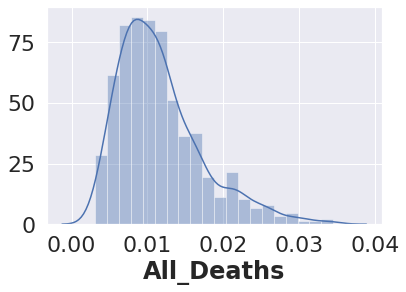

In [265]:
sns.distplot(Ward_Mortality_df_pop['All_Deaths'])

In [266]:
merged_disease_sat_food_mortality = pd.merge(left=merged_disease_sat_food,right=Ward_Mortality_df_pop, left_on='GSS_CODE', right_on='WD16CD')

In [267]:
merged_disease_sat_food_mortality['age_65+'] = merged_disease_sat_food_mortality['age_65+']/merged_disease_sat_food_mortality['Population']

In [268]:
merged_disease_sat_food_mortality['age_18_64'] = merged_disease_sat_food_mortality['age_18_64']/merged_disease_sat_food_mortality['Population']

In [269]:
merged_disease_sat_food_mortality['age_0_17'] = merged_disease_sat_food_mortality['age_0_17']/merged_disease_sat_food_mortality['Population']

In [270]:
len(merged_disease_sat_food_mortality)

473

In [1437]:
fields =  list(merged_disease_sat_food_mortality)

In [1438]:
merged_disease_sat_food_mortality.to_csv('Merged_all_disease_green_sat.csv')

In [1439]:
fields

['green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 u'psoriasis_Prescriptions',
 u'psoriasis_Prevalence',
 u"Meniere's disease_Prescriptions",
 u"Meniere's disease_Prevalence",
 u"crohn's disease_Prescriptions",
 u"crohn's disease_Prevalence",
 u'gastroparesis_Prescriptions',
 u'gastroparesis_Prevalence',
 u'irritable bowel syndrome_Prescriptions',
 u'irritable bowel syndrome_Prevalence',
 u'parkinson_Prescriptions',
 u'parkinson_Prevalence',
 u'sleep apnea_Prescriptions',
 u'sleep apnea_Prevalence',
 u'interstitial cystitis_Prescriptions',
 u'interstitial cystitis_Prevalence',
 u'bipolar_Prescriptions',
 u'bipolar_Prevalence',
 u'hypothyroidism_Prescriptions

In [1440]:
sampled_fields =['green_score','TreeScore','GLUD_Area of Greenspace PCT','LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT','age_0_17',
 'age_18_64',
 'age_65+',
 'avg_age',
 'area_sq_km',
 'people_per_sq_km']

In [1441]:
from scipy import stats
def meaningfulAllVsAllCorrs(dataFrame):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in dataFrame.columns:
        for y in dataFrame.columns:
            try:
                corr = stats.pearsonr(pd.to_numeric(dataFrame[x]), pd.to_numeric(dataFrame[y]))
                df_corr.loc[x,y] = corr[0]
                df_p.loc[x,y] = corr[1]
            except:
                print "Unparsable column"
    return df_corr , df_p

def getSignificantCorrs(corrFrame, pFrame, ColName , pthresh = 0.001, corrThresh = 0.2):
    significantCorrs = {}
    for y in corrFrame.columns:
        if pFrame[ColName][y] < pthresh:
            if abs(corrFrame[ColName][y]) > corrThresh:
                significantCorrs[y] = corrFrame[ColName][y]
    return(significantCorrs)


def getSignificantCorrsWithFields(corrFrame, pFrame, ColName , varName , pthresh = 0.01, corrThresh = 0.2):
    significantCorrs = {}
    for y in varName:
        if pFrame[ColName][y] < pthresh:
            if abs(corrFrame[ColName][y]) > corrThresh:
                significantCorrs[y] = corrFrame[ColName][y]
    return(significantCorrs)

In [1442]:
correlations , p_values = meaningfulAllVsAllCorrs(merged_disease_sat_food_mortality)

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

In [1443]:
significantPd = getSignificantCorrs(correlations,p_values ,'asthma_Prescriptions',corrThresh = 0.25)

KeyError: 'asthma_Prescriptions'

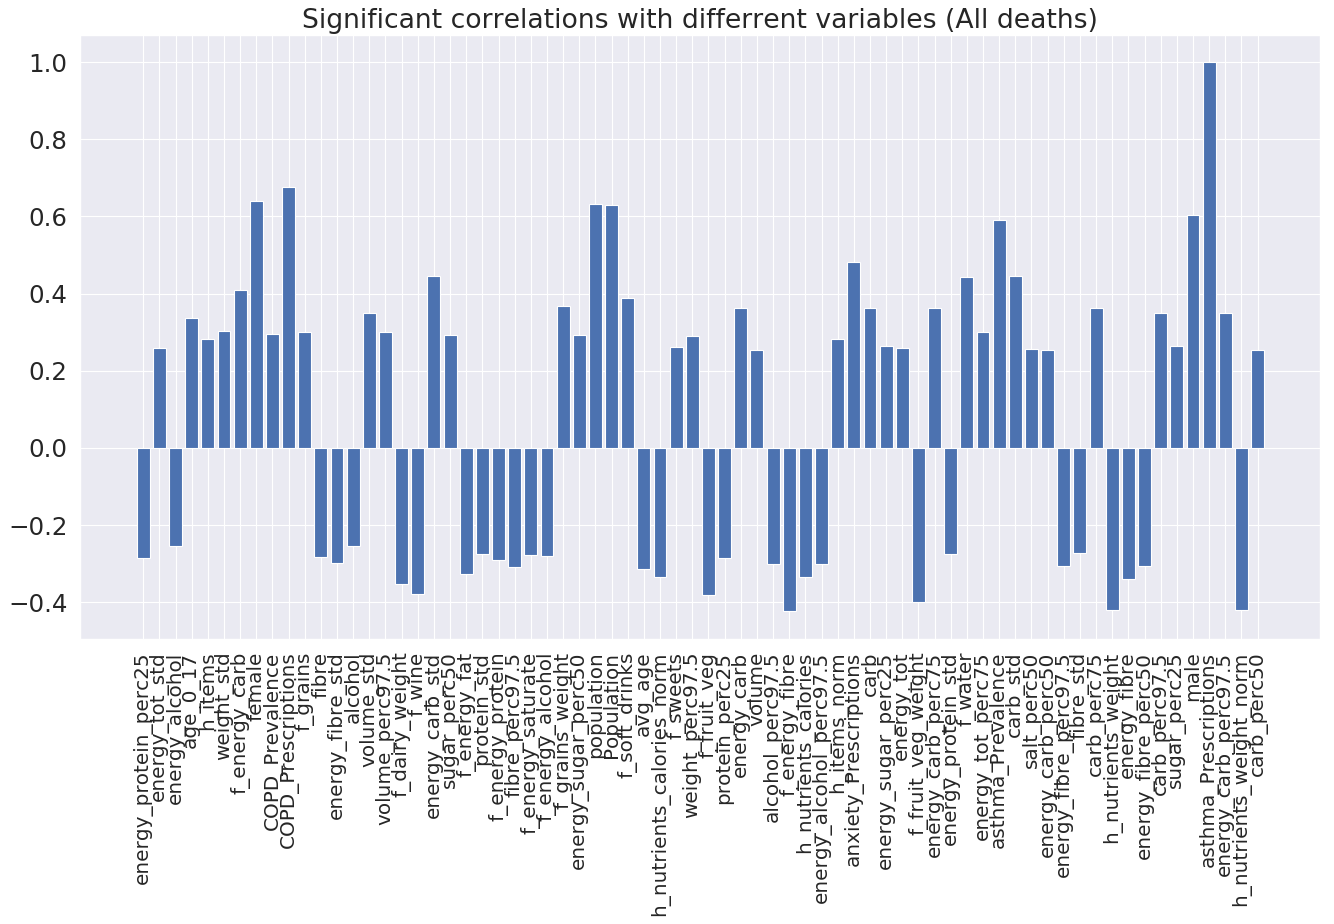

In [1346]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd)), list(significantPd.values()), align='center')
plt.xticks(range(len(significantPd)), list(significantPd.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (All deaths)')
plt.show()

In [1353]:
significantPd_green = getSignificantCorrsWithFields(correlations,p_values ,'COPD_Prescriptions',sampled_fields ,corrThresh = 0.1)

In [1354]:
significantPd_green

{'GLUD_Area of Greenspace PCT': 0.16696906787838472,
 'LCM_urban_pct': -0.17013172977613325,
 'StreetTrees_PCT': 0.18336447378709392,
 'TreeScore': -0.18670535322194193,
 'age_0_17': 0.30798739724362534,
 'age_18_64': -0.1387854350435107,
 'area_sq_km': 0.22234769357852094,
 'avg_age': -0.15568134652856386,
 'green_score': 0.1804081751857552}

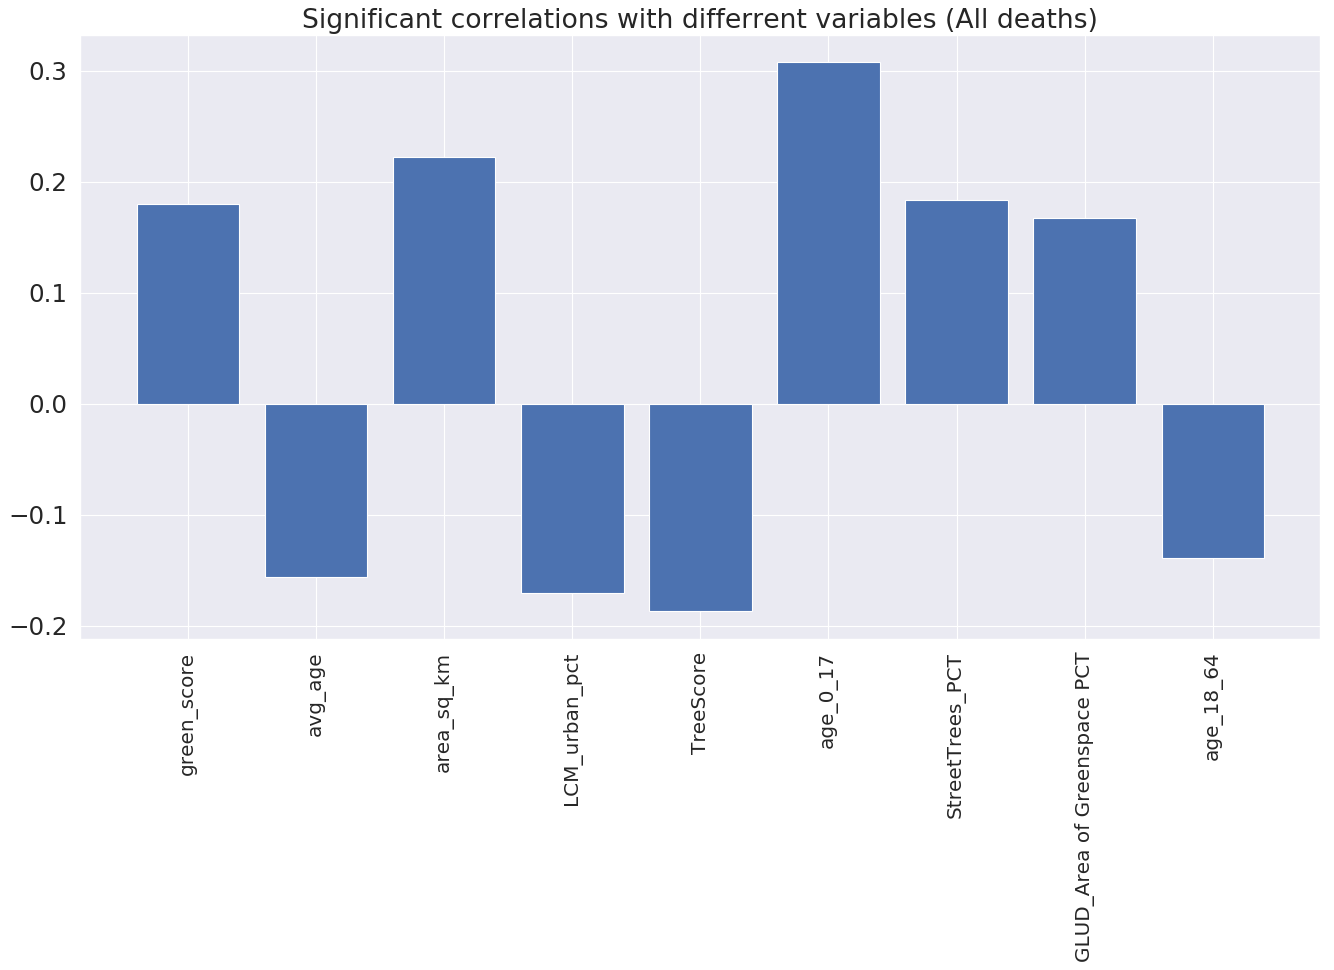

In [1355]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd_green)), list(significantPd_green.values()), align='center')
plt.xticks(range(len(significantPd_green)), list(significantPd_green.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (All deaths)')
plt.show()

In [1356]:
significantPd_green = getSignificantCorrsWithFields(correlations,p_values ,'asthma_Prevalence',sampled_fields ,corrThresh = 0.1)

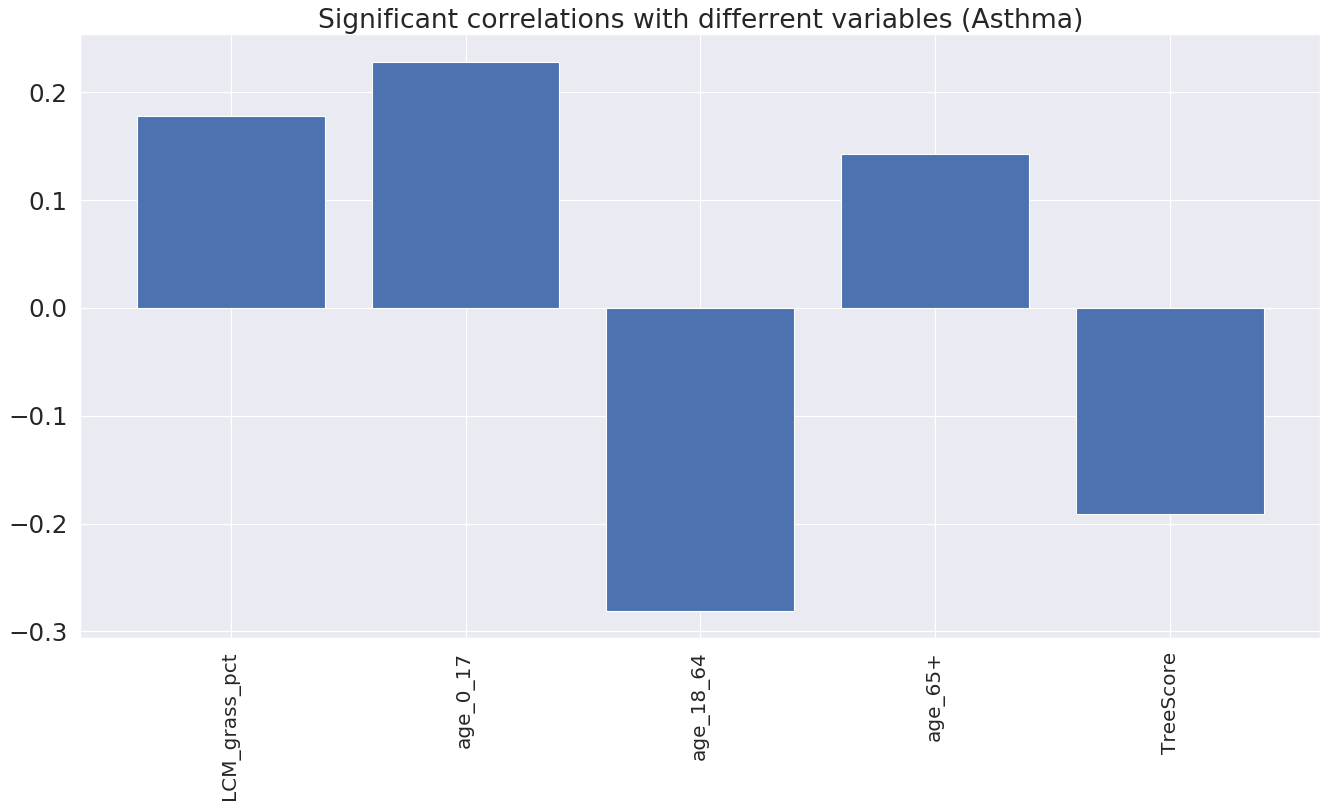

In [1383]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd_green)), list(significantPd_green.values()), align='center')
plt.xticks(range(len(significantPd_green)), list(significantPd_green.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (Asthma)')
plt.show()

In [1360]:
merged_disease_sat_food_mortality['GSV_decile'] = pd.qcut(merged_disease_sat_food_mortality['TreeScore'], q=4, precision=0)
merged_disease_sat_food_mortality['Satellite_decile'] = pd.qcut(merged_disease_sat_food_mortality['GLUD_Area of Greenspace PCT'], q=4, precision=0)
merged_disease_sat_food_mortality['age_decile'] = pd.qcut(merged_disease_sat_food_mortality['age_65+'], q=4, precision=0)

In [1366]:
corrs_decile = []
bins_decile = []
for name, group in merged_disease_sat_food_mortality.groupby('Satellite_decile'):
    bins_decile.append(name)
    corr = pearsonr(group['TreeScore'],group['asthma_Prevalence'])
    corrs_decile.append(corr)

In [1367]:
bins_decile

[Interval(-0.08, 0.1, closed='right'),
 Interval(0.1, 0.2, closed='right'),
 Interval(0.2, 0.4, closed='right'),
 Interval(0.4, 0.8, closed='right')]

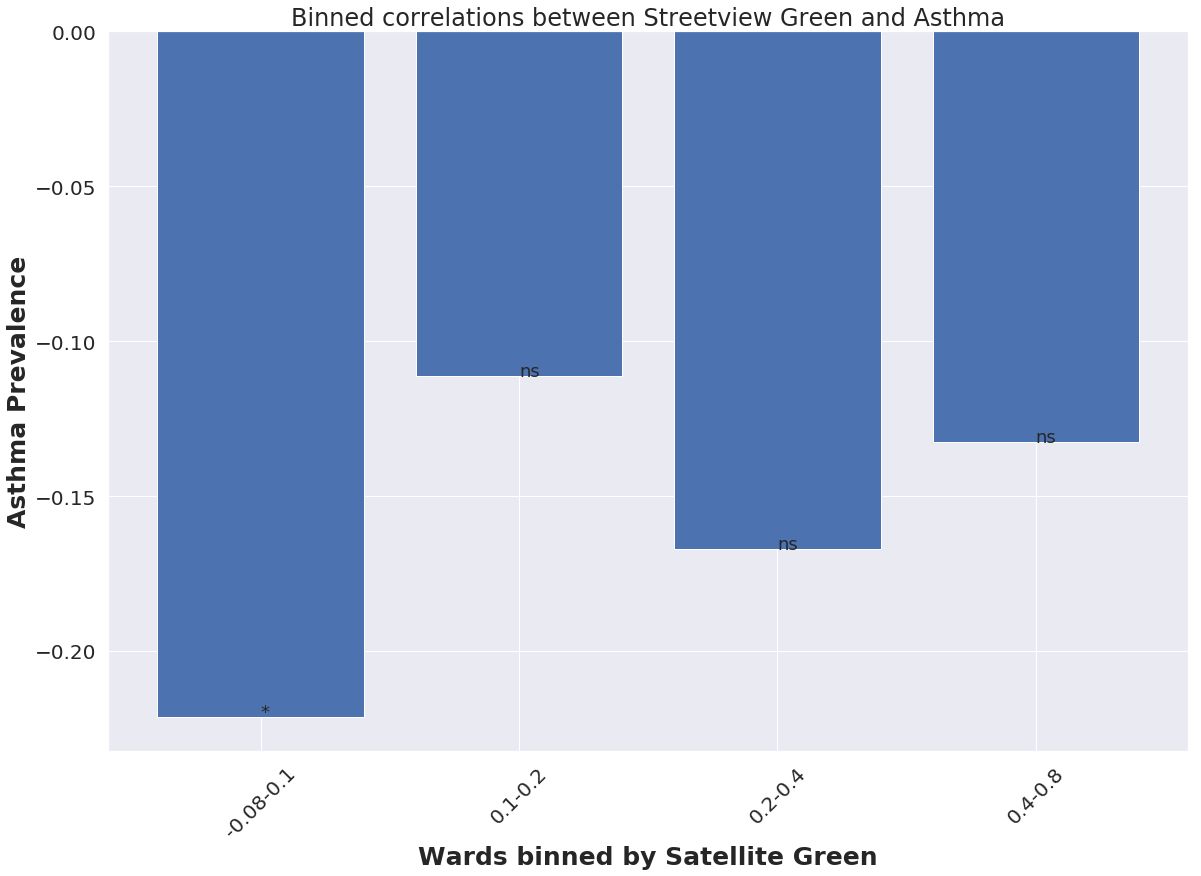

In [1368]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Satellite Green",fontsize = 25)
plt.ylabel("Asthma Prevalence",fontsize = 25)
plt.title("Binned correlations between Streetview Green and Asthma")
xlabels = [str(b.left)+'-'+str(b.right) for b in bins_decile]
c = [corr[0] for corr in corrs_decile]
ax.bar(xlabels,c)

p = []
for corr in corrs_decile: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20,rotation = 45)
plt.yticks(fontsize=20)
plt.show()

In [1369]:
syntax = pd.read_csv('London_ward_space_syntax.csv')

In [1375]:
list(merged_syntax.columns)

['green_score',
 'GSS_CODE_x',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0_x',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 u'dehydration_Prescriptions',
 u'dehydration_Prevalence',
 u'anxiety_Prescriptions',
 u'anxiety_Prevalence',
 u'asthma_Prescriptions',
 u'asthma_Prevalence',
 u'COPD_Prescriptions',
 u'COPD_Prevalence',
 'Area',
 'area_id',
 'weight',
 'weight_perc2.5',
 'weight_perc25',
 'weight_perc50',
 'weight_perc75',
 'weight_perc97.5',
 'weight_std',
 'weight_ci95',
 'volume',
 'volume_perc2.5',
 'volume_perc25',
 'volume_perc50',
 'volume_perc75',
 'volume_perc97.5',
 'volume_std',
 'volume_ci95',
 'fat',
 'fat_perc2.5',
 'fat_perc25',
 'fat_perc50',
 'fat_perc75',
 'fat_perc97.5',
 'fat_std',
 'fat_ci95',
 'satu

In [1372]:
merged_syntax = pd.merge(merged_disease_sat_food_mortality,syntax , left_on='WD17CD' , right_on='GSS_CODE')

In [1373]:
len(merged_syntax)

424

In [1378]:
SelectedFields = ['green_score','WD17CD','GLUD_Area of Greenspace PCT','UA_Public Greenery PCT','StreetTrees_PCT','TreeScore',
                  'h_nutrients_calories_norm','weight','Population','Choice','Choice_std','Integration','Integration_std',
                 'anxiety_Prescriptions','anxiety_Prevalence','asthma_Prescriptions','asthma_Prevalence']
syntax_df = merged_syntax[SelectedFields]

In [1384]:
syntax_df[['TreeScore','asthma_Prevalence', 'anxiety_Prevalence' ,'Choice','Integration','GLUD_Area of Greenspace PCT','UA_Public Greenery PCT']].corr()

,TreeScore,asthma_Prevalence,anxiety_Prevalence,Choice,Integration,GLUD_Area of Greenspace PCT,UA_Public Greenery PCT
TreeScore,1.000000,-0.191103,0.104475,0.618749,0.664484,-0.624835,-0.254337
asthma_Prevalence,-0.191103,1.000000,0.290004,-0.241629,-0.261640,0.115153,0.017815
anxiety_Prevalence,0.104475,0.290004,1.000000,-0.020467,-0.052399,0.060752,-0.005146
Choice,0.618749,-0.241629,-0.020467,1.000000,0.941607,-0.525489,-0.301470
Integration,0.664484,-0.261640,-0.052399,0.941607,1.000000,-0.576207,-0.277035
GLUD_Area of Greenspace PCT,-0.624835,0.115153,0.060752,-0.525489,-0.576207,1.000000,0.450626
UA_Public Greenery PCT,-0.254337,0.017815,-0.005146,-0.301470,-0.277035,0.450626,1.000000
